In [ ]:
!pip install pymoo

# R-NSGA2

## 数据准备

In [ ]:
import requests
import numpy as np

def read_ttp_data(filename):
    """
    读取TTP问题数据文件
    参数:
        filename: str, 文件名 (例如: 'a280-n279.txt')
    返回:
        distance_matrix: np.array, 城市间距离矩阵
        items: np.array, 物品信息 [序号, 利润, 重量, 所在城市编号]
        dimension: int, 城市数量
        items_count: int, 物品数量
    """
    # 构建GitHub原始文件URL
    base_url = "https://raw.githubusercontent.com/blankjul/gecco19-thief/master/src/main/resources/"
    url = base_url + filename

    # 下载数据文件
    response = requests.get(url)
    if response.status_code != 200:
        raise Exception(f"无法下载文件 {filename}")

    data = response.text.strip().split('\n')

    # 解析数据
    dimension = 0
    items_count = 0
    coordinates = []
    items = []

    reading_coords = False
    reading_items = False

    for line in data:
        if "DIMENSION" in line:
            dimension = int(line.split()[-1])
        elif "NUMBER OF ITEMS" in line:
            items_count = int(line.split()[-1])
        elif "NODE_COORD_SECTION" in line:
            reading_coords = True
            reading_items = False
            continue
        elif "ITEMS SECTION" in line:
            reading_coords = False
            reading_items = True
            continue

        if reading_coords:
            _, x, y = map(float, line.split())
            coordinates.append([x, y])
        elif reading_items:
            if line.strip() and not line.startswith("EOF"):
                item_id, profit, weight, node = map(int, line.split())
                # 添加物品序号作为第一列，节点编号从0开始
                items.append([item_id, profit, weight, node])

    # 转换为numpy数组
    coordinates = np.array(coordinates)
    items = np.array(items)

    # 计算城市间距离矩阵
    distance_matrix = np.zeros((dimension, dimension))
    for i in range(dimension):
        for j in range(dimension):
            if i != j:
                dx = coordinates[i][0] - coordinates[j][0]
                dy = coordinates[i][1] - coordinates[j][1]
                distance_matrix[i][j] = np.sqrt(dx*dx + dy*dy)

    # print(f"成功读取文件: {filename}")
    # print(f"城市数量: {dimension}")
    # print(f"物品数量: {items_count}")
    # print(f"距离矩阵形状: {distance_matrix.shape}")
    # print(f"物品信息形状: {items.shape}")
    # print(f"物品信息格式: [序号, 利润, 重量, 所在城市编号]")

    return distance_matrix, items, dimension, items_count

# 使用示例
# distance_matrix, items, dimension, items_count = read_ttp_data('a280-n279.txt')


In [ ]:
distance_matrix, items, cities_count, items_count = read_ttp_data('a280-n1395.txt')
print(distance_matrix[:6, :6])
print(items[:10])
# print(items[:3, 2])

[[ 0.         20.         24.08318916 32.984845   32.984845   42.75511665]
 [20.          0.         18.43908891 34.17601498 42.52058325 50.47771786]
 [24.08318916 18.43908891  0.         16.1245155  27.78488798 33.9411255 ]
 [32.984845   34.17601498 16.1245155   0.         16.         18.86796226]
 [32.984845   42.52058325 27.78488798 16.          0.         10.        ]
 [42.75511665 50.47771786 33.9411255  18.86796226 10.          0.        ]]
[[   1    1 1008    2]
 [   2  896 1006    3]
 [   3  367 1006    4]
 [   4  690 1001    5]
 [   5  613 1006    6]
 [   6  874 1001    7]
 [   7  122 1009    8]
 [   8  486 1004    9]
 [   9  823 1001   10]
 [  10  463 1003   11]]


In [ ]:
import numpy as np
import requests

def read_rp(filename):

  # 下载数据文件的raw内容
  base_url = "https://raw.githubusercontent.com/blankjul/gecco19-thief/master/submissions/HPI/"
  url = base_url + filename

  rp_response = requests.get(url)

  # 将数据按行分割
  data = rp_response.text.splitlines()

  # 提取 x 和 y 值
  coordinates = []
  for line in data:
      # 忽略空行和非数据行
      if line.strip() == "" or line.startswith("#"):
          continue
      # 提取坐标值 (x, y)
      values = line.split()
      if len(values) >= 2:  # 确保有两个值
          x = float(values[0])
          y = -float(values[1])
          coordinates.append([x, y])
  return np.array(coordinates)

## 固定初始解

### 固定解算法1

In [ ]:
import random
import numpy as np
# 0-based(第一座城市为城市0，最后为279)
def generate_initial_solutions(pop_size, n_cities, n_items, items, C,  random_seed=None):
    """
    生成RNSGA2算法的初始解

    参数:
        pop_size: 种群大小
        n_cities: 城市总数
        n_items: 物品总数
        random_seed: 随机种子

    返回:
        city_routes: 城市路径序列数组 shape=(pop_size, n_cities)
        item_selections: 物品选择序列数组 shape=(pop_size, n_items)
    """
    capacity = np.sum(items[:, 2]) * (C/11)

    if random_seed is not None:
        np.random.seed(random_seed)

    # 生成城市路径序列
    # city_routes = np.zeros((pop_size, 99), dtype=np.int32)
    city_routes = np.zeros((pop_size, n_cities-1), dtype=np.int32)
    item_selections = np.zeros((pop_size, n_items), dtype=np.int32)
    for i in range(pop_size):
        # city_routes[i] = (np.random.permutation(n_cities-1)+1)[:99]
        city_routes[i] = np.random.permutation(n_cities-1)+1

        current_weight = 0

        # 遍历路径上的每个城市
        for city in city_routes[i]:
            # 找出当前城市的所有物品
            city_items = np.where(items[:, 3] == city)[0]

            # 尝试选择该城市的物品
            for item_idx in city_items:
                if current_weight + items[item_idx, 2] <= capacity:
                    item_selections[i][item_idx] = 1
                    current_weight += items[item_idx, 2]

    return city_routes, item_selections

In [ ]:
# distance_matrix, items, cities_count, items_count = read_ttp_data('fnl4461-n44600.txt')
distance_matrix_test, items_test, cities_count_test, items_count_test = read_ttp_data('a280-n279.txt')
city_routes_test, item_selections_test = generate_initial_solutions(3, cities_count, items_count, items, 1, 114514)
# path, selections = generate_initial_solutions(1, 280, items_count, items, 1, distance_matrix)
print(city_routes_test)
print(city_routes_test.shape)
# print(item_selections_test)

[[198 225 119 129  37 145  84 172  75  99 224  17  48 261 126  18 279  55
   89  20  43  42 249 264  70  38 269 220 219 278 217  77 206  29 210 192
  147 134 102  41   2 184 247  11 136 235  57 240   6 152 128  93 226 202
   30 183   8 191 266  28 274 273  27  12 135  97  15 223 110   3  21 114
   60  47 121  68 211  62 209 141 100  51 238  67 122 214  90  64  34 133
  175 254 277 164 155 265  88 239 250 268 252 236 232 230 142  49 244 227
  233 105 165  13 243  10 193  65 208 144 174 270 157  40  16 271 218 253
   25  23  81 163 138 246  87 160 188  98 200 257 107  96 112 199  85 166
    7 182 190 186  66 263  26   5 275 196 234 245 173 150  54  94  79  58
  158 207 237 125  31 132  69  14 169  71  52   9  53 148  72 153  95  91
    1 222 178 149 113 151 109 204 272 103  73 146 179 162  76  59 116 185
  216 139 156 259 201 205 256 176 159 260  82 168  83 203 101 251 276  74
  171 111 231  63 229   4  86 215 104 213 242 117  92  78 255  19  32  56
  120 118  50 124 189 241  39  35 187 

### 固定解算法2（贪心机制生成路径初始解）

In [ ]:
import random
import numpy as np
# 0-based
def greedy_tsp_with_random_second(distance_matrix, start_city=1):
    n = len(distance_matrix)
    unvisited = set(range(n))
    # unvisited.remove(start_city)
    unvisited.remove(0)
    path = []
    total_distance = 0

    # 随机选择第一个城市
    start_city = random.choice(list(unvisited))
    # second_city = min(unvisited, key=lambda x: distance_matrix[start_city][x])
    path.append(start_city)
    unvisited.remove(start_city)
    total_distance += distance_matrix[0][start_city]

    # 继续使用贪心策略构建剩余路径
    while unvisited:
        last = path[-1]
        next_city = min(unvisited, key=lambda x: distance_matrix[last][x])
        path.append(next_city)
        unvisited.remove(next_city)
        total_distance += distance_matrix[last][next_city]

    return path, total_distance

def greedy_get_selections(items, max_capacity, value_weight_ratio):
    """
    使用贪心算法选择物品，考虑总容量限制。

    参数:
        items: 物品数组，每行包含[价值,利润,重量,城市]
        max_capacity: 总背包容量

    返回:
        selections: 物品选择数组(0-1)
    """
    n_items = len(items)

    # 根据性重比排序的索引
    sorted_indices = np.argsort(-value_weight_ratio)

    selections = np.zeros(n_items, dtype=np.int32)
    current_total_weight = 0

    # 按性重比从大到小遍历物品
    for idx in sorted_indices:
        item_weight = items[idx, 2]

        # 检查总容量限制
        if np.random.rand() < 0.5:
          if current_total_weight + item_weight <= max_capacity:
              selections[idx] = 1
              current_total_weight += item_weight

    return selections

def generate_initial_solutions(pop_size, n_cities, n_items, items, C, distance_matrix, random_seed=None):
    """
    生成RNSGA2算法的初始解

    参数:
        pop_size: 种群大小
        n_cities: 城市总数
        n_items: 物品总数
        random_seed: 随机种子

    返回:
        city_routes: 城市路径序列数组 shape=(pop_size, n_cities)
        item_selections: 物品选择序列数组 shape=(pop_size, n_items)
    """
    start_city = 1  # 固定起点为城市1

    total_capacity = np.sum(items[:, 2]) * (C/11)
    value_weight_ratio = (items[:, 1] / items[:, 2]**2)
    # print(value_weight_ratio)

    if random_seed is not None:
        np.random.seed(random_seed)
        random.seed(random_seed)

    # 生成城市路径序列
    city_routes = np.zeros((pop_size, n_cities-1), dtype=np.int32)
    item_selections = np.zeros((pop_size, n_items), dtype=np.int32)

    for i in range(pop_size):
        path, distance = greedy_tsp_with_random_second(distance_matrix, start_city)
        city_routes[i] = path

        # 使用贪心算法选择物品，加入负重限制
        item_selections[i] = greedy_get_selections(items, total_capacity, value_weight_ratio)

    return city_routes, item_selections

In [ ]:
distance_matrix, items, dimension, items_count = read_ttp_data('a280-n2790.txt')

path, selections = generate_initial_solutions(3, 280, items_count, items, 1, distance_matrix, 114514)
# path, selections = generate_initial_solutions(1, 280, items_count, items, 1, distance_matrix)
print(path)
print(path.shape)
print(selections)
# print(selections.shape)

[[120 119 118 156 157 158 159 174 160 161 162 163 164 165 166 167 168 100
   99  98  97  92  93  94  95  96  91  90  89  88 108 107 103 102 101 169
  170 171 172 105 104 106 173 109 110 113 112  86  83  82  81  80  79  78
   75  74  73  72  71  70  69  66  65  64  63  62  61 117  60  59  42  41
   40  39  38  37  36  35  34  33  32  30  29 124 123 122 121 153 154 152
  155 151 150 176 175 180 179 178 177 149 148 138 137 136 135 134 133 269
  268 267 266 265 139 140 141 142 143 144 145 146 147 264 263 262 261 260
  259 258 257 256 253 252 207 206 209 208 251 254 255 248 247 246 243 240
  239 238 237 230 231 232 233 234 235 236 245 244 249 250 229 228 227 226
  225 224 223 222 221 218 217 214 213 210 211 212 215 216 219 220 202 201
  199 198 197 196 193 194 195 200 192 191 190 189 188 187 186 184 183 182
  181 185 203 204 205 277 278   2 279   1 241 242   3 276 275 274 273 272
  271 270  15  16  17  18  19  20 127 126 125  28  27  26  25  21  24  22
   23  13  12  11  10   9   7   6   8 

In [ ]:
f1, f2 = evaluate_function(1, path, selections, distance_matrix, items, 1)
print(f1)
print(f2)

[47301.72373598]
[-336997.]


### 固定解算法3 （无变化）

In [ ]:
import random
import numpy as np
# 0-based
def greedy_tsp_with_random_second(distance_matrix, start_city=1):
    n = len(distance_matrix)
    unvisited = set(range(n))
    # unvisited.remove(start_city)
    unvisited.remove(0)
    path = []
    total_distance = 0

    # 随机选择第一个城市
    start_city = random.choice(list(unvisited))
    # second_city = min(unvisited, key=lambda x: distance_matrix[start_city][x])
    path.append(start_city)
    unvisited.remove(start_city)
    total_distance += distance_matrix[0][start_city]

    # 继续使用贪心策略构建剩余路径
    while unvisited:
        last = path[-1]
        next_city = min(unvisited, key=lambda x: distance_matrix[last][x])
        path.append(next_city)
        unvisited.remove(next_city)
        total_distance += distance_matrix[last][next_city]

    return path, total_distance

def greedy_get_selections(items, max_capacity, value_weight_ratio):
    """
    使用贪心算法选择物品，考虑总容量限制。

    参数:
        items: 物品数组，每行包含[价值,利润,重量,城市]
        max_capacity: 总背包容量

    返回:
        selections: 物品选择数组(0-1)
    """
    n_items = len(items)

    # 根据性重比排序的索引
    sorted_indices = np.argsort(-value_weight_ratio)

    selections = np.zeros(n_items, dtype=np.int32)
    current_total_weight = 0

    # 按性重比从大到小遍历物品
    for idx in sorted_indices:
        item_weight = items[idx, 2]

        # 检查总容量限制
        if np.random.rand() < 0.5:
          if current_total_weight + item_weight <= max_capacity:
              selections[idx] = 1
              current_total_weight += item_weight

    return selections

def generate_initial_solutions(pop_size, n_cities, n_items, items, C, distance_matrix, random_seed=None):
    """
    生成RNSGA2算法的初始解

    参数:
        pop_size: 种群大小
        n_cities: 城市总数
        n_items: 物品总数
        random_seed: 随机种子

    返回:
        city_routes: 城市路径序列数组 shape=(pop_size, n_cities)
        item_selections: 物品选择序列数组 shape=(pop_size, n_items)
    """
    start_city = 1  # 固定起点为城市1

    total_capacity = np.sum(items[:, 2]) * (C/11)
    value_weight_ratio = (items[:, 1] / items[:, 2]**2)
    # print(value_weight_ratio)

    if random_seed is not None:
        np.random.seed(random_seed)
        random.seed(random_seed)

    # 生成城市路径序列
    city_routes = np.zeros((pop_size, n_cities-1), dtype=np.int32)
    item_selections = np.zeros((pop_size, n_items), dtype=np.int32)

    for i in range(pop_size):
        path, distance = greedy_tsp_with_random_second(distance_matrix, start_city)
        city_routes[i] = path

        # 使用贪心算法选择物品，加入负重限制
        item_selections[i] = greedy_get_selections(items, total_capacity, value_weight_ratio)

    return city_routes, item_selections

## R-NSGA2 框架

### Framework

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

# ============ 评估函数 ============
# 0-based
# items为1based
def evaluate_function(pop_size, city_routes, item_selections, distance_matrix, items, C):
    """
    计算种群中每个个体的两个目标值:
      f1: 总时间 (需最小化)
      f2: -总价值 (同样采用最小化表述, 因此取负值)
    """
    f1 = np.zeros(pop_size)
    f2 = np.zeros(pop_size)

    for i in range(pop_size):
        # 构造完整路径 (起点0 -> 中间城市 -> 回到0)
        path_i = city_routes[i]
        full_path = np.concatenate(([0], path_i, [0]))

        current_speed = 1.0
        current_weight = 0.0
        total_time = 0.0
        total_value = 0.0

        for j in range(len(full_path) - 1):
            from_city = full_path[j]
            to_city = full_path[j+1]

            # 找到此城市对应的物品index
            city_mask = (items[:, 3] == from_city)
            # item_selections[i][k] == 1表示选了该物品
            selected_mask = item_selections[i][items[:, 0] - 1] == 1

            # 叠加在当前城市选中的物品
            chosen_here = items[city_mask & selected_mask]
            if len(chosen_here) > 0:
                current_weight += np.sum(chosen_here[:, 2])  # 重量
                total_value += np.sum(chosen_here[:, 1])     # 价值

            # 根据载重来计算速度
            current_speed = max(0.1, 1.0 - (current_weight / C) * 0.9)

            # 计算该路段的时间
            dist = distance_matrix[from_city, to_city]
            total_time += dist / current_speed

        # 存储目标值
        f1[i] = total_time
        f2[i] = -total_value   # 负值便于最小化

    return f1, f2


# ============ 快速非支配排序（做了小优化：只遍历半个矩阵） ============

def fast_non_dominated_sort(F):
    """
    针对 2 维目标值 F (N x 2), 返回 fronts (多层前沿的索引列表) 以及 rank (每个个体的层级).
    这里仍是最常见的O(N^2)思路，但减少了一半的重复判断。
    若要在2D下进一步提速，可考虑"按F1排序+分层剥离"算法。
    """
    N = len(F)
    # S[p] : 存放被p支配的解的索引
    S = [[] for _ in range(N)]
    # n[q] : 被多少个解支配
    n = np.zeros(N, dtype=np.int32)
    # rank[i] : 第 i 个解所在的前沿层级(从0开始)
    rank = np.zeros(N, dtype=np.int32)

    # --------- 先按F1排序，然后剥离 ---------
    F1_sorted_indices = np.argsort(F[:, 0])
    for i in range(N - 1):
        p = F1_sorted_indices[i]
        for j in range(i + 1, N):
            q = F1_sorted_indices[j]
            # p是否支配q
            if (F[p, 0] <= F[q, 0] and F[p, 1] < F[q, 1]) or \
               (F[p, 0] < F[q, 0] and F[p, 1] <= F[q, 1]):
                S[p].append(q)
                n[q] += 1
            # q是否支配p
            elif (F[q, 0] <= F[p, 0] and F[q, 1] < F[p, 1]) or \
                 (F[q, 0] < F[p, 0] and F[q, 1] <= F[p, 1]):
                S[q].append(p)
                n[p] += 1

    # --------- 找出第一前沿 ---------
    front = []
    for i in range(N):
        if n[i] == 0:
            rank[i] = 0
            front.append(i)

    fronts = []
    i = 0
    while front:
        # 存储当前前沿
        fronts.append(front)
        next_front = []
        # 针对当前前沿内的所有点，找它们支配的解
        for p in front:
            for q in S[p]:
                n[q] -= 1
                if n[q] == 0:
                    rank[q] = i + 1
                    next_front.append(q)
        i += 1
        front = next_front

    return fronts, rank


# ============ 拥挤距离（与原版类似，针对当前front里的索引批量计算） ============

def crowding_distance(F, front_indices):
    """
    针对某一前沿面的个体，计算其拥挤距离。
    front_indices: list of int, 该前沿面里个体在全局的索引。
    返回: 与 front_indices 同顺序的拥挤距离列表。
    """
    l = len(front_indices)
    if l <= 2:
        return [float('inf')] * l

    # 初始化
    distances = [0.0] * l

    # 对每个目标分别计算
    for m in range(F.shape[1]):
        # 以该目标的值排序
        sorted_idx = sorted(range(l), key=lambda i: F[front_indices[i], m])
        # 两端的拥挤距离设为无穷
        distances[sorted_idx[0]] = float('inf')
        distances[sorted_idx[-1]] = float('inf')

        f_min = F[front_indices[sorted_idx[0]], m]
        f_max = F[front_indices[sorted_idx[-1]], m]
        denom = f_max - f_min if f_max > f_min else 1e-14

        for i in range(1, l - 1):
            left_idx = front_indices[sorted_idx[i - 1]]
            right_idx = front_indices[sorted_idx[i + 1]]
            distances[sorted_idx[i]] += (F[right_idx, m] - F[left_idx, m]) / denom

    return distances


# ============ 参考点距离计算 ============

def rp_calculation(front_F, reference_points):
    """
    针对最后一层前沿(front_F)做简单的min-max归一化后,
    计算每个解到各个参考点的欧几里得距离.
      - front_F: shape (n_sol_in_front, 2)
      - reference_points: shape (n_ref, 2)
    返回: (n_sol_in_front x n_ref) 的矩阵
    """
    n_sol = len(front_F)
    n_ref = len(reference_points)
    distances = np.zeros((n_sol, n_ref))

    # 1) min-max 归一化
    f1_min, f1_max = np.min(front_F[:, 0]), np.max(front_F[:, 0])
    f2_min, f2_max = np.min(front_F[:, 1]), np.max(front_F[:, 1])
    denom_f1 = f1_max - f1_min if (f1_max > f1_min) else 1e-14
    denom_f2 = f2_max - f2_min if (f2_max > f2_min) else 1e-14

    F_norm = np.zeros_like(front_F)
    F_norm[:, 0] = (front_F[:, 0] - f1_min) / denom_f1
    F_norm[:, 1] = (front_F[:, 1] - f2_min) / denom_f2

    # 2) 逐个解计算到参考点的欧几里得距离
    for i in range(n_sol):
        for j in range(n_ref):
            distances[i, j] = np.linalg.norm(F_norm[i] - reference_points[j])

    return distances


# ============ 锦标赛产生子代 ============

def generate_children(pop_size, path, selections, capacity, rank, cd_all, items, seen):
    """
    以锦标赛选择 (结合rank, 再平级比拥挤距离) 产生pop_size个子代个体.
    """
    offspring_path = []
    offspring_selections = []
    total_individuals = len(path)

    while len(offspring_path) < pop_size:
        # 随机选2个做第一个父母
        c1 = random.sample(range(total_individuals), 2)
        if rank[c1[0]] < rank[c1[1]]:
            p1 = c1[0]
        elif rank[c1[0]] > rank[c1[1]]:
            p1 = c1[1]
        else:
            p1 = c1[0] if cd_all[c1[0]] > cd_all[c1[1]] else c1[1]

        # 随机再选2个做第二个父母
        c2 = random.sample(range(total_individuals), 2)
        if rank[c2[0]] < rank[c2[1]]:
            p2 = c2[0]
        elif rank[c2[0]] > rank[c2[1]]:
            p2 = c2[1]
        else:
            p2 = c2[0] if cd_all[c2[0]] > cd_all[c2[1]] else c2[1]

        child_p, child_s = crossover_mutation(
            path[p1], selections[p1],
            path[p2], selections[p2],
            items, capacity
        )
        key = (tuple(child_p), tuple(child_s))

        # 只有不重复的子代才会被添加
        if key not in seen:
            seen.add(key)
            offspring_path.append(child_p)
            offspring_selections.append(child_s)

    return np.array(offspring_path), np.array(offspring_selections), seen


# ============ OX交叉 + 简易装包示例 ============

def crossover_mutation(parent1_path, parent1_sel, parent2_path, parent2_sel, items, capacity):
    size = len(parent1_path)
    # 两点交叉位置
    point1, point2 = sorted(random.sample(range(size), 2))

    # --------- OX交叉产生子路径 ---------
    child_path = np.zeros(size, dtype=np.int32)
    child_path[point1:point2] = parent1_path[point1:point2]

    remaining = [city for city in parent2_path if city not in child_path[point1:point2]]
    idx_rem = 0
    for i in range(size):
        if child_path[i] == 0:
            child_path[i] = remaining[idx_rem]
            idx_rem += 1

    # --------- 简单装包策略: 从头开始尽量放 ---------
    child_sel = np.zeros(len(items), dtype=np.int32)
    current_weight = 0.0
    for city in child_path:
        item_indices = np.where(items[:, 3] == city)[0]
        for idx in item_indices:
            w = items[idx, 2]
            if current_weight + w <= capacity:
                child_sel[idx] = 1
                current_weight += w
            else:
                # 超出容量就不选
                pass

    return child_path, child_sel


# ============ 基于参考点的种群选择 (pop_selection) ============

def pop_selection(fronts, F, pop_size, reference_points):
    """
    在NSGA-III / R-NSGA2思路下的选择：
      1) 对可整层接纳的前沿, 直接收入下一代
      2) 对无法整层收入的最后一层front, 用参考点分配 + 距离升序挑选
    """
    selected_indices = []
    remaining = pop_size
    last_front = None

    # ---------- 先整层收入 ----------
    for front in fronts:
        if len(selected_indices) + len(front) < pop_size:
            selected_indices.extend(front)
            remaining = pop_size - len(selected_indices)
        elif len(selected_indices) + len(front) == pop_size:
            selected_indices.extend(front)
            remaining = 0
            break
        else:
            last_front = front
            break

    if remaining == 0 or last_front is None:
        return selected_indices

    # ---------- 对无法整层接纳的最后前沿做参考点分配 ----------
    front_F = F[last_front]
    dist_mat = rp_calculation(front_F, reference_points)  # shape (len(last_front), n_ref)

    # 找到每个解最近的参考点 (clusters[c] 存储若干解(索引+距离))
    assignments = np.argmin(dist_mat, axis=1)
    clusters = [[] for _ in range(len(reference_points))]
    for i, global_idx in enumerate(last_front):
        ref_idx = assignments[i]
        clusters[ref_idx].append((global_idx, dist_mat[i, ref_idx]))

    # 簇内按照"离参考点的距离升序"排序
    for c in clusters:
        c.sort(key=lambda x: x[1])

    # ---------- 轮流从各簇中选解，直到凑满 ----------
    while remaining > 0:
        any_selected = False
        for c in clusters:
            if c and remaining > 0:
                # 选该簇中距离最近的那一个
                selected_indices.append(c[0][0])
                c.pop(0)
                remaining -= 1
                any_selected = True
                if remaining == 0:
                    break
        if not any_selected:
            # 所有簇都空了
            break

    return selected_indices


# ============ 主循环：R-NSGA2 / NSGA-III 示例 ============

def R_NSGA2(pop_size, n_gens, reference_points,
            cities_count, items_count, items, C,
            random_seed, distance_matrix,
            path, selections):
    """
    以R-NSGA2 / NSGA-III方式进行迭代:
      - path: shape (pop_size, route_len)
      - selections: shape (pop_size, items_count)
      - reference_points: 事先定义好的参考点数组
    返回:
      - 最终第一前沿的路线, 背包选择, 以及其 (f1, f2)
    """
    if random_seed is not None:
      random.seed(random_seed)
      np.random.seed(random_seed)

    # 简单定义capacity（可自行修改）
    capacity = np.sum(items[:, 2]) * (C / 11.0)
    seen = set()
    for i in range(pop_size):
        key = (tuple(path[i]), tuple(selections[i]))
        seen.add(key)

    for gen in range(n_gens):
        # ========== 评估父代适应度 ==========
        f1, f2 = evaluate_function(len(path), path, selections, distance_matrix, items, C)
        F = np.column_stack((f1, f2))

        # ========== 非支配排序 + 拥挤距离计算 ==========
        fronts, rank = fast_non_dominated_sort(F)

        cd_all = np.zeros(len(path))
        for fr in fronts:
            cd_front = crowding_distance(F, fr)
            for i, idx in enumerate(fr):
                cd_all[idx] = cd_front[i]

        # ========== 产生子代 (锦标赛选择 + 交叉变异) ==========
        child_path, child_selections, seen = generate_children(
            pop_size, path, selections, capacity, rank, cd_all, items, seen
        )

        # ========== 合并父子两代，再次评估 + 非支配排序 ==========
        path = np.vstack((path, child_path))
        selections = np.vstack((selections, child_selections))

        f1, f2 = evaluate_function(len(path), path, selections, distance_matrix, items, C)
        F = np.column_stack((f1, f2))
        fronts, rank = fast_non_dominated_sort(F)

        cd_all = np.zeros(len(path))
        for fr in fronts:
            cd_front = crowding_distance(F, fr)
            for i, idx in enumerate(fr):
                cd_all[idx] = cd_front[i]

        # ========== 基于参考点的选择 (NSGA-III/R-NSGA2) ==========
        chosen = pop_selection(fronts, F, pop_size, reference_points)

        # 缩小到pop_size
        path = path[chosen]
        selections = selections[chosen]

    # ========== 最终结果 ==========
    f1, f2 = evaluate_function(len(path), path, selections, distance_matrix, items, C)
    F = np.column_stack((f1, f2))
    final_fronts, final_rank = fast_non_dominated_sort(F)

    # 绘制结果分布
    plt.figure(figsize=(8, 6))
    plt.scatter(f1, -f2, c='blue', edgecolors='k', alpha=0.7, label='All solutions')
    plt.scatter(f1[final_fronts[0]], -f2[final_fronts[0]],
                c='red', edgecolors='k', alpha=0.7, label='First Front')
    # plt.scatter(reference_points[:,0], -reference_points[:,1], c='yellow', marker='*', s=80)
    plt.title("Objective Space (R-NSGA2) - Gen {}".format(n_gens))
    plt.xlabel("F1 (time cost)")
    plt.ylabel("F2 (value)")
    plt.legend()
    plt.grid(alpha=0.5)
    plt.show()

    # 返回第一前沿的信息
    best_paths = path[final_fronts[0]]
    best_sels = selections[final_fronts[0]]
    best_F = F[final_fronts[0]]
    return best_paths, best_sels, best_F


### Framework 2(贪心机制生成路径初始解版本，无变化)

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

# ============ 评估函数 ============
# 0-based
# items为1based
def evaluate_function(pop_size, city_routes, item_selections, distance_matrix, items, C):
    """
    计算种群中每个个体的两个目标值:
      f1: 总时间 (需最小化)
      f2: -总价值 (同样采用最小化表述, 因此取负值)
    """
    f1 = np.zeros(pop_size)
    f2 = np.zeros(pop_size)

    for i in range(pop_size):
        # 构造完整路径 (起点0 -> 中间城市 -> 回到0)
        path_i = city_routes[i]
        full_path = np.concatenate(([0], path_i, [0]))

        current_speed = 1.0
        current_weight = 0.0
        total_time = 0.0
        total_value = 0.0

        for j in range(len(full_path) - 1):
            from_city = full_path[j]
            to_city = full_path[j+1]

            # 找到此城市对应的物品index
            city_mask = (items[:, 3] == from_city)
            # item_selections[i][k] == 1表示选了该物品
            selected_mask = item_selections[i][items[:, 0] - 1] == 1

            # 叠加在当前城市选中的物品
            chosen_here = items[city_mask & selected_mask]
            if len(chosen_here) > 0:
                current_weight += np.sum(chosen_here[:, 2])  # 重量
                total_value += np.sum(chosen_here[:, 1])     # 价值

            # 根据载重来计算速度
            current_speed = max(0.1, 1.0 - (current_weight / C) * 0.9)

            # 计算该路段的时间
            dist = distance_matrix[from_city, to_city]
            total_time += dist / current_speed

        # 存储目标值
        f1[i] = total_time
        f2[i] = -total_value   # 负值便于最小化

    return f1, f2


# ============ 快速非支配排序（做了小优化：只遍历半个矩阵） ============

def fast_non_dominated_sort(F):
    """
    针对 2 维目标值 F (N x 2), 返回 fronts (多层前沿的索引列表) 以及 rank (每个个体的层级).
    这里仍是最常见的O(N^2)思路，但减少了一半的重复判断。
    若要在2D下进一步提速，可考虑"按F1排序+分层剥离"算法。
    """
    N = len(F)
    # S[p] : 存放被p支配的解的索引
    S = [[] for _ in range(N)]
    # n[q] : 被多少个解支配
    n = np.zeros(N, dtype=np.int32)
    # rank[i] : 第 i 个解所在的前沿层级(从0开始)
    rank = np.zeros(N, dtype=np.int32)

    # --------- 先按F1排序，然后剥离 ---------
    F1_sorted_indices = np.argsort(F[:, 0])
    for i in range(N - 1):
        p = F1_sorted_indices[i]
        for j in range(i + 1, N):
            q = F1_sorted_indices[j]
            # p是否支配q
            if (F[p, 0] <= F[q, 0] and F[p, 1] < F[q, 1]) or \
               (F[p, 0] < F[q, 0] and F[p, 1] <= F[q, 1]):
                S[p].append(q)
                n[q] += 1
            # q是否支配p
            elif (F[q, 0] <= F[p, 0] and F[q, 1] < F[p, 1]) or \
                 (F[q, 0] < F[p, 0] and F[q, 1] <= F[p, 1]):
                S[q].append(p)
                n[p] += 1

    # --------- 找出第一前沿 ---------
    front = []
    for i in range(N):
        if n[i] == 0:
            rank[i] = 0
            front.append(i)

    fronts = []
    i = 0
    while front:
        # 存储当前前沿
        fronts.append(front)
        next_front = []
        # 针对当前前沿内的所有点，找它们支配的解
        for p in front:
            for q in S[p]:
                n[q] -= 1
                if n[q] == 0:
                    rank[q] = i + 1
                    next_front.append(q)
        i += 1
        front = next_front

    return fronts, rank


# ============ 拥挤距离（与原版类似，针对当前front里的索引批量计算） ============

def crowding_distance(F, front_indices):
    """
    针对某一前沿面的个体，计算其拥挤距离。
    front_indices: list of int, 该前沿面里个体在全局的索引。
    返回: 与 front_indices 同顺序的拥挤距离列表。
    """
    l = len(front_indices)
    if l <= 2:
        return [float('inf')] * l

    # 初始化
    distances = [0.0] * l

    # 对每个目标分别计算
    for m in range(F.shape[1]):
        # 以该目标的值排序
        sorted_idx = sorted(range(l), key=lambda i: F[front_indices[i], m])
        # 两端的拥挤距离设为无穷
        distances[sorted_idx[0]] = float('inf')
        distances[sorted_idx[-1]] = float('inf')

        f_min = F[front_indices[sorted_idx[0]], m]
        f_max = F[front_indices[sorted_idx[-1]], m]
        denom = f_max - f_min if f_max > f_min else 1e-14

        for i in range(1, l - 1):
            left_idx = front_indices[sorted_idx[i - 1]]
            right_idx = front_indices[sorted_idx[i + 1]]
            distances[sorted_idx[i]] += (F[right_idx, m] - F[left_idx, m]) / denom

    return distances


# ============ 参考点距离计算 ============

def rp_calculation(front_F, reference_points):
    """
    针对最后一层前沿(front_F)做简单的min-max归一化后,
    计算每个解到各个参考点的欧几里得距离.
      - front_F: shape (n_sol_in_front, 2)
      - reference_points: shape (n_ref, 2)
    返回: (n_sol_in_front x n_ref) 的矩阵
    """
    n_sol = len(front_F)
    n_ref = len(reference_points)
    distances = np.zeros((n_sol, n_ref))

    # 1) min-max 归一化
    f1_min, f1_max = np.min(front_F[:, 0]), np.max(front_F[:, 0])
    f2_min, f2_max = np.min(front_F[:, 1]), np.max(front_F[:, 1])
    denom_f1 = f1_max - f1_min if (f1_max > f1_min) else 1e-14
    denom_f2 = f2_max - f2_min if (f2_max > f2_min) else 1e-14

    F_norm = np.zeros_like(front_F)
    F_norm[:, 0] = (front_F[:, 0] - f1_min) / denom_f1
    F_norm[:, 1] = (front_F[:, 1] - f2_min) / denom_f2

    # 2) 逐个解计算到参考点的欧几里得距离
    for i in range(n_sol):
        for j in range(n_ref):
            distances[i, j] = np.linalg.norm(F_norm[i] - reference_points[j])

    return distances


# ============ 锦标赛产生子代 ============

def generate_children(pop_size, path, selections, capacity, rank, cd_all, items, seen):
    """
    以锦标赛选择 (结合rank, 再平级比拥挤距离) 产生pop_size个子代个体.
    """
    offspring_path = []
    offspring_selections = []
    total_individuals = len(path)

    while len(offspring_path) < pop_size:
        # 随机选2个做第一个父母
        c1 = random.sample(range(total_individuals), 2)
        if rank[c1[0]] < rank[c1[1]]:
            p1 = c1[0]
        elif rank[c1[0]] > rank[c1[1]]:
            p1 = c1[1]
        else:
            p1 = c1[0] if cd_all[c1[0]] > cd_all[c1[1]] else c1[1]

        # 随机再选2个做第二个父母
        c2 = random.sample(range(total_individuals), 2)
        if rank[c2[0]] < rank[c2[1]]:
            p2 = c2[0]
        elif rank[c2[0]] > rank[c2[1]]:
            p2 = c2[1]
        else:
            p2 = c2[0] if cd_all[c2[0]] > cd_all[c2[1]] else c2[1]

        child_p, child_s = crossover_mutation(
            path[p1], selections[p1],
            path[p2], selections[p2],
            items, capacity
        )
        key = (tuple(child_p), tuple(child_s))

        # 只有不重复的子代才会被添加
        if key not in seen:
            seen.add(key)
            offspring_path.append(child_p)
            offspring_selections.append(child_s)

    return np.array(offspring_path), np.array(offspring_selections), seen


# ============ OX交叉 + 简易装包示例 ============

def crossover_mutation(parent1_path, parent1_sel, parent2_path, parent2_sel, items, capacity):
    size = len(parent1_path)
    # 两点交叉位置
    point1, point2 = sorted(random.sample(range(size), 2))

    # --------- OX交叉产生子路径 ---------
    child_path = np.zeros(size, dtype=np.int32)
    child_path[point1:point2] = parent1_path[point1:point2]

    remaining = [city for city in parent2_path if city not in child_path[point1:point2]]
    idx_rem = 0
    for i in range(size):
        if child_path[i] == 0:
            child_path[i] = remaining[idx_rem]
            idx_rem += 1

    # --------- 简单装包策略: 从头开始尽量放 ---------
    child_sel = np.zeros(len(items), dtype=np.int32)
    current_weight = 0.0
    for city in child_path:
        item_indices = np.where(items[:, 3] == city)[0]
        for idx in item_indices:
            w = items[idx, 2]
            if current_weight + w <= capacity:
                child_sel[idx] = 1
                current_weight += w
            else:
                # 超出容量就不选
                pass

    return child_path, child_sel


# ============ 基于参考点的种群选择 (pop_selection) ============

def pop_selection(fronts, F, pop_size, reference_points):
    """
    在NSGA-III / R-NSGA2思路下的选择：
      1) 对可整层接纳的前沿, 直接收入下一代
      2) 对无法整层收入的最后一层front, 用参考点分配 + 距离升序挑选
    """
    selected_indices = []
    remaining = pop_size
    last_front = None

    # ---------- 先整层收入 ----------
    for front in fronts:
        if len(selected_indices) + len(front) < pop_size:
            selected_indices.extend(front)
            remaining = pop_size - len(selected_indices)
        elif len(selected_indices) + len(front) == pop_size:
            selected_indices.extend(front)
            remaining = 0
            break
        else:
            last_front = front
            break

    if remaining == 0 or last_front is None:
        return selected_indices

    # ---------- 对无法整层接纳的最后前沿做参考点分配 ----------
    front_F = F[last_front]
    dist_mat = rp_calculation(front_F, reference_points)  # shape (len(last_front), n_ref)

    # 找到每个解最近的参考点 (clusters[c] 存储若干解(索引+距离))
    assignments = np.argmin(dist_mat, axis=1)
    clusters = [[] for _ in range(len(reference_points))]
    for i, global_idx in enumerate(last_front):
        ref_idx = assignments[i]
        clusters[ref_idx].append((global_idx, dist_mat[i, ref_idx]))

    # 簇内按照"离参考点的距离升序"排序
    for c in clusters:
        c.sort(key=lambda x: x[1])

    # ---------- 轮流从各簇中选解，直到凑满 ----------
    while remaining > 0:
        any_selected = False
        for c in clusters:
            if c and remaining > 0:
                # 选该簇中距离最近的那一个
                selected_indices.append(c[0][0])
                c.pop(0)
                remaining -= 1
                any_selected = True
                if remaining == 0:
                    break
        if not any_selected:
            # 所有簇都空了
            break

    return selected_indices


# ============ 主循环：R-NSGA2 / NSGA-III 示例 ============

def R_NSGA2(pop_size, n_gens, reference_points,
            cities_count, items_count, items, C,
            random_seed, distance_matrix,
            path, selections):
    """
    以R-NSGA2 / NSGA-III方式进行迭代:
      - path: shape (pop_size, route_len)
      - selections: shape (pop_size, items_count)
      - reference_points: 事先定义好的参考点数组
    返回:
      - 最终第一前沿的路线, 背包选择, 以及其 (f1, f2)
    """
    if random_seed is not None:
      random.seed(random_seed)
      np.random.seed(random_seed)

    # 简单定义capacity（可自行修改）
    capacity = np.sum(items[:, 2]) * (C / 11.0)
    seen = set()
    for i in range(pop_size):
        key = (tuple(path[i]), tuple(selections[i]))
        seen.add(key)

    for gen in range(n_gens):
        # ========== 评估父代适应度 ==========
        f1, f2 = evaluate_function(len(path), path, selections, distance_matrix, items, C)
        F = np.column_stack((f1, f2))

        # ========== 非支配排序 + 拥挤距离计算 ==========
        fronts, rank = fast_non_dominated_sort(F)

        cd_all = np.zeros(len(path))
        for fr in fronts:
            cd_front = crowding_distance(F, fr)
            for i, idx in enumerate(fr):
                cd_all[idx] = cd_front[i]

        # ========== 产生子代 (锦标赛选择 + 交叉变异) ==========
        child_path, child_selections, seen = generate_children(
            pop_size, path, selections, capacity, rank, cd_all, items, seen
        )

        # ========== 合并父子两代，再次评估 + 非支配排序 ==========
        path = np.vstack((path, child_path))
        selections = np.vstack((selections, child_selections))

        f1, f2 = evaluate_function(len(path), path, selections, distance_matrix, items, C)
        F = np.column_stack((f1, f2))
        fronts, rank = fast_non_dominated_sort(F)

        cd_all = np.zeros(len(path))
        for fr in fronts:
            cd_front = crowding_distance(F, fr)
            for i, idx in enumerate(fr):
                cd_all[idx] = cd_front[i]

        # ========== 基于参考点的选择 (NSGA-III/R-NSGA2) ==========
        chosen = pop_selection(fronts, F, pop_size, reference_points)

        # 缩小到pop_size
        path = path[chosen]
        selections = selections[chosen]

    # ========== 最终结果 ==========
    f1, f2 = evaluate_function(len(path), path, selections, distance_matrix, items, C)
    F = np.column_stack((f1, f2))
    final_fronts, final_rank = fast_non_dominated_sort(F)

    # 绘制结果分布
    plt.figure(figsize=(8, 6))
    plt.scatter(f1, -f2, c='blue', edgecolors='k', alpha=0.7, label='All solutions')
    plt.scatter(f1[final_fronts[0]], -f2[final_fronts[0]],
                c='red', edgecolors='k', alpha=0.7, label='First Front')
    # plt.scatter(reference_points[:,0], -reference_points[:,1], c='yellow', marker='*', s=80)
    plt.title("Objective Space (R-NSGA2) - Gen {}".format(n_gens))
    plt.xlabel("F1 (time cost)")
    plt.ylabel("F2 (value)")
    plt.legend()
    plt.grid(alpha=0.5)
    plt.show()

    # 返回第一前沿的信息
    best_paths = path[final_fronts[0]]
    best_sels = selections[final_fronts[0]]
    best_F = F[final_fronts[0]]
    return best_paths, best_sels, best_F


### Framework3 （交叉变异改进版）

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

# ============ 评估函数 ============
# 0-based
# items为1based
def evaluate_function(pop_size, city_routes, item_selections, distance_matrix, items, C):
    """
    计算种群中每个个体的两个目标值:
      f1: 总时间 (需最小化)
      f2: -总价值 (同样采用最小化表述, 因此取负值)
    """
    f1 = np.zeros(pop_size)
    f2 = np.zeros(pop_size)

    for i in range(pop_size):
        # 构造完整路径 (起点0 -> 中间城市 -> 回到0)
        path_i = city_routes[i]
        full_path = np.concatenate(([0], path_i, [0]))

        current_speed = 1.0
        current_weight = 0.0
        total_time = 0.0
        total_value = 0.0

        for j in range(len(full_path) - 1):
            from_city = full_path[j]
            to_city = full_path[j+1]

            # 找到此城市对应的物品index
            city_mask = (items[:, 3] == from_city)
            # item_selections[i][k] == 1表示选了该物品
            selected_mask = item_selections[i][items[:, 0] - 1] == 1

            # 叠加在当前城市选中的物品
            chosen_here = items[city_mask & selected_mask]
            if len(chosen_here) > 0:
                current_weight += np.sum(chosen_here[:, 2])  # 重量
                total_value += np.sum(chosen_here[:, 1])     # 价值

            # 根据载重来计算速度
            current_speed = max(0.1, 1.0 - (current_weight / C) * 0.9)

            # 计算该路段的时间
            dist = distance_matrix[from_city, to_city]
            total_time += dist / current_speed

        # 存储目标值
        f1[i] = total_time
        f2[i] = -total_value   # 负值便于最小化

    return f1, f2


# ============ 快速非支配排序（做了小优化：只遍历半个矩阵） ============

def fast_non_dominated_sort(F):
    """
    针对 2 维目标值 F (N x 2), 返回 fronts (多层前沿的索引列表) 以及 rank (每个个体的层级).
    这里仍是最常见的O(N^2)思路，但减少了一半的重复判断。
    若要在2D下进一步提速，可考虑"按F1排序+分层剥离"算法。
    """
    N = len(F)
    # S[p] : 存放被p支配的解的索引
    S = [[] for _ in range(N)]
    # n[q] : 被多少个解支配
    n = np.zeros(N, dtype=np.int32)
    # rank[i] : 第 i 个解所在的前沿层级(从0开始)
    rank = np.zeros(N, dtype=np.int32)

    # --------- 先按F1排序，然后剥离 ---------
    F1_sorted_indices = np.argsort(F[:, 0])
    for i in range(N - 1):
        p = F1_sorted_indices[i]
        for j in range(i + 1, N):
            q = F1_sorted_indices[j]
            # p是否支配q
            if (F[p, 0] <= F[q, 0] and F[p, 1] < F[q, 1]) or \
               (F[p, 0] < F[q, 0] and F[p, 1] <= F[q, 1]):
                S[p].append(q)
                n[q] += 1
            # q是否支配p
            elif (F[q, 0] <= F[p, 0] and F[q, 1] < F[p, 1]) or \
                 (F[q, 0] < F[p, 0] and F[q, 1] <= F[p, 1]):
                S[q].append(p)
                n[p] += 1

    # --------- 找出第一前沿 ---------
    front = []
    for i in range(N):
        if n[i] == 0:
            rank[i] = 0
            front.append(i)

    fronts = []
    i = 0
    while front:
        # 存储当前前沿
        fronts.append(front)
        next_front = []
        # 针对当前前沿内的所有点，找它们支配的解
        for p in front:
            for q in S[p]:
                n[q] -= 1
                if n[q] == 0:
                    rank[q] = i + 1
                    next_front.append(q)
        i += 1
        front = next_front

    return fronts, rank


# ============ 拥挤距离（与原版类似，针对当前front里的索引批量计算） ============

def crowding_distance(F, front_indices):
    """
    针对某一前沿面的个体，计算其拥挤距离。
    front_indices: list of int, 该前沿面里个体在全局的索引。
    返回: 与 front_indices 同顺序的拥挤距离列表。
    """
    l = len(front_indices)
    if l <= 2:
        return [float('inf')] * l

    # 初始化
    distances = [0.0] * l

    # 对每个目标分别计算
    for m in range(F.shape[1]):
        # 以该目标的值排序
        sorted_idx = sorted(range(l), key=lambda i: F[front_indices[i], m])
        # 两端的拥挤距离设为无穷
        distances[sorted_idx[0]] = float('inf')
        distances[sorted_idx[-1]] = float('inf')

        f_min = F[front_indices[sorted_idx[0]], m]
        f_max = F[front_indices[sorted_idx[-1]], m]
        denom = f_max - f_min if f_max > f_min else 1e-14

        for i in range(1, l - 1):
            left_idx = front_indices[sorted_idx[i - 1]]
            right_idx = front_indices[sorted_idx[i + 1]]
            distances[sorted_idx[i]] += (F[right_idx, m] - F[left_idx, m]) / denom

    return distances


# ============ 参考点距离计算 ============

def rp_calculation(front_F, reference_points):
    """
    针对最后一层前沿(front_F)做简单的min-max归一化后,
    计算每个解到各个参考点的欧几里得距离.
      - front_F: shape (n_sol_in_front, 2)
      - reference_points: shape (n_ref, 2)
    返回: (n_sol_in_front x n_ref) 的矩阵
    """
    n_sol = len(front_F)
    n_ref = len(reference_points)
    distances = np.zeros((n_sol, n_ref))

    # 1) min-max 归一化
    f1_min, f1_max = np.min(front_F[:, 0]), np.max(front_F[:, 0])
    f2_min, f2_max = np.min(front_F[:, 1]), np.max(front_F[:, 1])
    denom_f1 = f1_max - f1_min if (f1_max > f1_min) else 1e-14
    denom_f2 = f2_max - f2_min if (f2_max > f2_min) else 1e-14

    F_norm = np.zeros_like(front_F)
    F_norm[:, 0] = (front_F[:, 0] - f1_min) / denom_f1
    F_norm[:, 1] = (front_F[:, 1] - f2_min) / denom_f2

    # 2) 逐个解计算到参考点的欧几里得距离
    for i in range(n_sol):
        for j in range(n_ref):
            distances[i, j] = np.linalg.norm(F_norm[i] - reference_points[j])

    return distances


# ============ 锦标赛产生子代 ============
def generate_children(pop_size, path, selections, capacity, rank, cd_all, items, distance_matrix, C, cross_rate, mut_rate, seen):
    """
    以锦标赛选择 (结合rank, 再平级比拥挤距离) 产生pop_size个子代个体.
    Args:
        cross_rate: 交叉概率
        mut_rate: 变异概率
    """
    offspring_path = []
    offspring_selections = []
    total_individuals = len(path)

    while len(offspring_path) < pop_size:
        # 随机选2个做第一个父母
        c1 = random.sample(range(total_individuals), 2)
        if rank[c1[0]] < rank[c1[1]]:
            p1 = c1[0]
        elif rank[c1[0]] > rank[c1[1]]:
            p1 = c1[1]
        else:
            p1 = c1[0] if cd_all[c1[0]] > cd_all[c1[1]] else c1[1]

        # 随机再选2个做第二个父母
        c2 = random.sample(range(total_individuals), 2)
        if rank[c2[0]] < rank[c2[1]]:
            p2 = c2[0]
        elif rank[c2[0]] > rank[c2[1]]:
            p2 = c2[1]
        else:
            p2 = c2[0] if cd_all[c2[0]] > cd_all[c2[1]] else c2[1]

        # 根据交叉率决定是否进行交叉
        if random.random() < cross_rate:
            child_p = crossover(path[p1], path[p2])
        else:
            child_p = sample_mutation(path[p1])

        # 根据变异率决定是否进行变异
        if random.random() < mut_rate:
            child_p = opt_mutation(child_p)

        # 根据路径生成物品选择
        if random.random() < cross_rate:
            # 进行贪心生成
            child_s = generate_selections_for_path(child_p, items, capacity, distance_matrix, C, mut_rate)
        else:
            # 直接继承父代的选择，并根据突变率随机将1变为0
            child_s = selections[p1].copy()
            for i in range(len(child_s)):
                if child_s[i] == 1 and random.random() < mut_rate:
                    child_s[i] = 0

        key = (tuple(child_p), tuple(child_s))

        # 只有不重复的子代才会被添加
        if key not in seen:
            seen.add(key)
            offspring_path.append(child_p)
            offspring_selections.append(child_s)

    return np.array(offspring_path), np.array(offspring_selections), seen


# ============ OX交叉 + 变异操作 ============

def crossover(parent1_path, parent2_path):
    """OX交叉产生子路径"""
    size = len(parent1_path)
    # 两点交叉位置
    point1, point2 = sorted(random.sample(range(size), 2))

    child_path = np.zeros(size, dtype=np.int32)
    child_path[point1:point2] = parent1_path[point1:point2]

    remaining = [city for city in parent2_path if city not in child_path[point1:point2]]
    idx_rem = 0
    for i in range(size):
        if child_path[i] == 0:
            child_path[i] = remaining[idx_rem]
            idx_rem += 1

    return child_path

def sample_mutation(path):
    """简单的交换变异"""
    mutated_path = path.copy()
    # 随机选择两个位置进行交换
    pos1, pos2 = random.sample(range(len(path)), 2)
    mutated_path[pos1], mutated_path[pos2] = mutated_path[pos2], mutated_path[pos1]
    return mutated_path

def opt_mutation(path):
    """2-opt的翻转变异"""
    size = len(path)
    mutated_path = path.copy()
    # 随机选择两个位置
    i, j = sorted(random.sample(range(size), 2))

    # 将i到j之间的路径段反转
    mutated_path[i:j+1] = mutated_path[i:j+1][::-1]
    return mutated_path

def generate_selections_for_path(path, items, capacity, distance_matrix, C, mut_rate):
    """
    根据给定路径生成物品选择，考虑路径时间成本
    加入变异率影响：变异率越高，越可能丢弃高价值解
    """
    n_items = len(items)
    selections = np.zeros(n_items, dtype=np.int32)

    # 构造完整路径
    full_path = np.concatenate(([0], path, [0]))

    # 计算每个物品的综合价值
    item_scores = np.zeros(n_items)
    current_weight = 0
    current_time = 0

    for i in range(len(full_path) - 1):
        from_city = full_path[i]
        to_city = full_path[i + 1]

        # 找到当前城市的物品
        city_items_mask = (items[:, 3] == from_city)
        city_items = np.where(city_items_mask)[0]

        # 计算当前路段的基础时间
        dist = distance_matrix[from_city, to_city]
        base_speed = max(0.1, 1.0 - (current_weight / C) * 0.9)
        current_time += dist / base_speed

        # 为当前城市的每个物品计算综合得分
        for item_idx in city_items:
            item_weight = items[item_idx, 2]
            item_value = items[item_idx, 1]

            # 计算选择该物品后的额外时间成本
            new_speed = max(0.1, 1.0 - ((current_weight + item_weight) / C) * 0.9)
            time_cost = dist * (1/new_speed - 1/base_speed)

            # 综合得分 = 价值/重量比 - 时间成本权重
            item_scores[item_idx] = (item_value / item_weight) - 0.1 * time_cost

    # 根据综合得分排序
    sorted_items = np.argsort(-item_scores)

    # 贪心选择物品，但根据变异率可能跳过高价值解
    current_weight = 0
    for idx in sorted_items:
        item_weight = items[idx, 2]
        if current_weight + item_weight <= capacity:
            # 根据变异率决定是否跳过该高价值解
            if random.random() > mut_rate:
                selections[idx] = 1
                current_weight += item_weight

    return selections

# ============ 基于参考点的种群选择 (pop_selection) ============

def pop_selection(fronts, F, pop_size, reference_points):
    """
    在NSGA-III / R-NSGA2思路下的选择：
      1) 对可整层接纳的前沿, 直接收入下一代
      2) 对无法整层收入的最后一层front, 用参考点分配 + 距离升序挑选
    """
    selected_indices = []
    remaining = pop_size
    last_front = None

    # ---------- 先整层收入 ----------
    for front in fronts:
        if len(selected_indices) + len(front) < pop_size:
            selected_indices.extend(front)
            remaining = pop_size - len(selected_indices)
        elif len(selected_indices) + len(front) == pop_size:
            selected_indices.extend(front)
            remaining = 0
            break
        else:
            last_front = front
            break

    if remaining == 0 or last_front is None:
        return selected_indices

    # ---------- 对无法整层接纳的最后前沿做参考点分配 ----------
    front_F = F[last_front]
    dist_mat = rp_calculation(front_F, reference_points)  # shape (len(last_front), n_ref)

    # 找到每个解最近的参考点 (clusters[c] 存储若干解(索引+距离))
    assignments = np.argmin(dist_mat, axis=1)
    clusters = [[] for _ in range(len(reference_points))]
    for i, global_idx in enumerate(last_front):
        ref_idx = assignments[i]
        clusters[ref_idx].append((global_idx, dist_mat[i, ref_idx]))

    # 簇内按照"离参考点的距离升序"排序
    for c in clusters:
        c.sort(key=lambda x: x[1])

    # ---------- 轮流从各簇中选解，直到凑满 ----------
    while remaining > 0:
        any_selected = False
        for c in clusters:
            if c and remaining > 0:
                # 选该簇中距离最近的那一个
                selected_indices.append(c[0][0])
                c.pop(0)
                remaining -= 1
                any_selected = True
                if remaining == 0:
                    break
        if not any_selected:
            # 所有簇都空了
            break

    return selected_indices


# ============ 主循环：R-NSGA2 / NSGA-III 示例 ============

def R_NSGA2(pop_size, n_gens, reference_points,
            cities_count, items_count, items, C,
            random_seed, distance_matrix,
            path, selections, cross_rate, mut_rate):
    """
    以R-NSGA2 / NSGA-III方式进行迭代:
      - path: shape (pop_size, route_len)
      - selections: shape (pop_size, items_count)
      - reference_points: 事先定义好的参考点数组
    返回:
      - 最终第一前沿的路线, 背包选择, 以及其 (f1, f2)
    """
    if random_seed is not None:
      random.seed(random_seed)
      np.random.seed(random_seed)

    # 简单定义capacity（可自行修改）
    capacity = np.sum(items[:, 2]) * (C / 11.0)

    seen = set()
    for i in range(pop_size):
        key = (tuple(path[i]), tuple(selections[i]))
        seen.add(key)

    for gen in range(n_gens):
        # ========== 评估父代适应度 ==========
        f1, f2 = evaluate_function(len(path), path, selections, distance_matrix, items, C)
        F = np.column_stack((f1, f2))

        # ========== 非支配排序 + 拥挤距离计算 ==========
        fronts, rank = fast_non_dominated_sort(F)

        cd_all = np.zeros(len(path))
        for fr in fronts:
            cd_front = crowding_distance(F, fr)
            for i, idx in enumerate(fr):
                cd_all[idx] = cd_front[i]

        # ========== 产生子代 (锦标赛选择 + 交叉变异) ==========
        child_path, child_selections, seen = generate_children(
            pop_size, path, selections, capacity, rank, cd_all, items, distance_matrix, C, cross_rate, mut_rate, seen
        )

        # ========== 合并父子两代，再次评估 + 非支配排序 ==========
        path = np.vstack((path, child_path))
        selections = np.vstack((selections, child_selections))

        f1, f2 = evaluate_function(len(path), path, selections, distance_matrix, items, C)
        F = np.column_stack((f1, f2))
        fronts, rank = fast_non_dominated_sort(F)

        cd_all = np.zeros(len(path))
        for fr in fronts:
            cd_front = crowding_distance(F, fr)
            for i, idx in enumerate(fr):
                cd_all[idx] = cd_front[i]

        # ========== 基于参考点的选择 (NSGA-III/R-NSGA2) ==========
        chosen = pop_selection(fronts, F, pop_size, reference_points)

        # 缩小到pop_size
        path = path[chosen]
        selections = selections[chosen]

    # ========== 最终结果 ==========
    f1, f2 = evaluate_function(len(path), path, selections, distance_matrix, items, C)
    F = np.column_stack((f1, f2))
    final_fronts, final_rank = fast_non_dominated_sort(F)

    # 绘制结果分布
    plt.figure(figsize=(8, 6))
    plt.scatter(f1, -f2, c='blue', edgecolors='k', alpha=0.7, label='All solutions')
    plt.scatter(f1[final_fronts[0]], -f2[final_fronts[0]],
                c='red', edgecolors='k', alpha=0.7, label='First Front')
    # plt.scatter(reference_points[:,0], -reference_points[:,1], c='yellow', marker='*', s=80)
    plt.title("Objective Space (R-NSGA2) - Gen {}".format(n_gens))
    plt.xlabel("F1 (time cost)")
    plt.ylabel("F2 (value)")
    plt.legend()
    plt.grid(alpha=0.5)
    plt.show()

    # 返回第一前沿的信息
    best_paths = path[final_fronts[0]]
    best_sels = selections[final_fronts[0]]
    best_F = F[final_fronts[0]]
    return best_paths, best_sels, best_F


### Framework3_opt（计算效率提高50%，多样性略微下降）

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

# ============ 评估函数 ============
# 0-based
# items为1based
def evaluate_function(pop_size, city_routes, item_selections, distance_matrix, items, C):
    """
    计算种群中每个个体的两个目标值:
      f1: 总时间 (需最小化)
      f2: -总价值 (同样采用最小化表述, 因此取负值)
    """
    f1 = np.zeros(pop_size)
    f2 = np.zeros(pop_size)

    # 预计算每个城市的物品索引
    city_items = {}
    for i in range(len(items)):
        city = items[i,3]
        if city not in city_items:
            city_items[city] = []
        city_items[city].append(i)

    for i in range(pop_size):
        path_i = city_routes[i]
        full_path = np.concatenate(([0], path_i, [0]))

        current_speed = 1.0
        current_weight = 0.0
        total_time = 0.0
        total_value = 0.0

        # 预计算选中的物品
        selected_items = np.where(item_selections[i] == 1)[0]
        selected_set = set(selected_items)

        for j in range(len(full_path) - 1):
            from_city = full_path[j]
            to_city = full_path[j+1]

            # 直接从预计算的城市物品中查找
            if from_city in city_items:
                city_items_indices = city_items[from_city]
                chosen_here = []
                for idx in city_items_indices:
                    if idx in selected_set:
                        chosen_here.append(items[idx])
                if chosen_here:
                    chosen_here = np.array(chosen_here)
                    current_weight += np.sum(chosen_here[:, 2])
                    total_value += np.sum(chosen_here[:, 1])

            current_speed = max(0.1, 1.0 - (current_weight / C) * 0.9)
            dist = distance_matrix[from_city, to_city]
            total_time += dist / current_speed

        f1[i] = total_time
        f2[i] = -total_value

    return f1, f2


# ============ 快速非支配排序（做了小优化：只遍历半个矩阵） ============

def fast_non_dominated_sort(F):
    """
    针对 2 维目标值 F (N x 2), 返回 fronts (多层前沿的索引列表) 以及 rank (每个个体的层级).
    这里仍是最常见的O(N^2)思路，但减少了一半的重复判断。
    若要在2D下进一步提速，可考虑"按F1排序+分层剥离"算法。
    """
    N = len(F)
    # 使用列表替代集合,减少转换开销
    S = [[] for _ in range(N)]
    n = np.zeros(N, dtype=np.int32)
    rank = np.zeros(N, dtype=np.int32)

    # 预排序优化
    F1_sorted_indices = np.argsort(F[:, 0])

    # 使用向量化操作判断支配关系
    for i in range(N - 1):
        p = F1_sorted_indices[i]
        p_values = F[p]

        # 批量比较
        q_indices = F1_sorted_indices[i+1:]
        q_values = F[q_indices]

        # 向量化判断p支配q
        p_dominates = ((p_values[0] <= q_values[:,0]) & (p_values[1] < q_values[:,1])) | \
                     ((p_values[0] < q_values[:,0]) & (p_values[1] <= q_values[:,1]))

        # 向量化判断q支配p
        q_dominates = ((q_values[:,0] <= p_values[0]) & (q_values[:,1] < p_values[1])) | \
                     ((q_values[:,0] < p_values[0]) & (q_values[:,1] <= p_values[1]))

        # 更新支配关系
        for idx, q in enumerate(q_indices):
            if p_dominates[idx]:
                S[p].append(q)
                n[q] += 1
            elif q_dominates[idx]:
                S[q].append(p)
                n[p] += 1

    # 找出第一前沿
    front = np.where(n == 0)[0].tolist()
    fronts = [front]
    i = 0

    while front:
        next_front = []
        for p in front:
            for q in S[p]:
                n[q] -= 1
                if n[q] == 0:
                    rank[q] = i + 1
                    next_front.append(q)
        i += 1
        front = next_front
        if front:
            fronts.append(front)

    return fronts, rank


# ============ 拥挤距离（与原版类似，针对当前front里的索引批量计算） ============

def crowding_distance(F, front_indices):
    """
    针对某一前沿面的个体，计算其拥挤距离。
    front_indices: list of int, 该前沿面里个体在全局的索引。
    返回: 与 front_indices 同顺序的拥挤距离列表。
    """
    l = len(front_indices)
    if l <= 2:
        return [float('inf')] * l

    # 初始化
    distances = np.zeros(l)
    front_F = F[front_indices]

    # 对每个目标分别计算
    for m in range(F.shape[1]):
        # 按目标值排序
        sorted_idx = np.argsort(front_F[:, m])

        # 两端设为无穷
        distances[sorted_idx[0]] = float('inf')
        distances[sorted_idx[-1]] = float('inf')

        # 归一化因子
        f_range = front_F[sorted_idx[-1], m] - front_F[sorted_idx[0], m]
        if f_range == 0:
            f_range = 1e-14

        # 向量化计算中间点的距离
        idx_range = sorted_idx[1:-1]
        if len(idx_range) > 0:
            prev_val = front_F[sorted_idx[:-2], m]
            next_val = front_F[sorted_idx[2:], m]
            distances[idx_range] += (next_val - prev_val) / f_range

    return distances


# ============ 参考点距离计算 ============

def rp_calculation(front_F, reference_points):
    """
    针对最后一层前沿(front_F)做简单的min-max归一化后,
    计算每个解到各个参考点的欧几里得距离.
      - front_F: shape (n_sol_in_front, 2)
      - reference_points: shape (n_ref, 2)
    返回: (n_sol_in_front x n_ref) 的矩阵
    """
    # 向量化的min-max归一化
    F_min = np.min(front_F, axis=0)
    F_max = np.max(front_F, axis=0)
    denom = np.maximum(F_max - F_min, 1e-14)
    F_norm = (front_F - F_min) / denom

    # 向量化的距离计算
    return np.sqrt(np.sum((F_norm[:, np.newaxis, :] - reference_points) ** 2, axis=2))


# ============ 锦标赛产生子代 ============
def generate_children(pop_size, path, selections, capacity, rank, cd_all, items, distance_matrix, C, cross_rate, mut_rate, seen):
    """
    以锦标赛选择 (结合rank, 再平级比拥挤距离) 产生pop_size个子代个体.
    Args:
        cross_rate: 交叉概率
        mut_rate: 变异概率
    """
    offspring_path = []
    offspring_selections = []
    total_individuals = len(path)

    # 随机数生成器
    tournament_pairs_idx = 0
    cross_decisions_idx = 0
    mut_decisions_idx = 0

    # 初始化随机数组
    tournament_pairs = np.random.randint(0, total_individuals, (1000, 2))
    cross_decisions = np.random.random(1000) < cross_rate
    mut_decisions = np.random.random(1000) < mut_rate

    while len(offspring_path) < pop_size:
        # 检查是否需要重新生成随机数
        if tournament_pairs_idx >= len(tournament_pairs):
            tournament_pairs = np.random.randint(0, total_individuals, (1000, 2))
            tournament_pairs_idx = 0

        if cross_decisions_idx >= len(cross_decisions):
            cross_decisions = np.random.random(1000) < cross_rate
            cross_decisions_idx = 0

        if mut_decisions_idx >= len(mut_decisions):
            mut_decisions = np.random.random(1000) < mut_rate
            mut_decisions_idx = 0

        # 锦标赛选择
        c1 = tournament_pairs[tournament_pairs_idx]
        c2 = tournament_pairs[(tournament_pairs_idx + 1) % len(tournament_pairs)]
        tournament_pairs_idx += 2

        p1 = c1[0] if (rank[c1[0]] < rank[c1[1]] or
                      (rank[c1[0]] == rank[c1[1]] and cd_all[c1[0]] > cd_all[c1[1]])) else c1[1]
        p2 = c2[0] if (rank[c2[0]] < rank[c2[1]] or
                      (rank[c2[0]] == rank[c2[1]] and cd_all[c2[0]] > cd_all[c2[1]])) else c2[1]

        # 根据预生成的决策进行交叉变异
        if cross_decisions[cross_decisions_idx]:
            child_p = crossover(path[p1], path[p2])
        else:
            child_p = sample_mutation(path[p1])
        cross_decisions_idx += 1

        if mut_decisions[mut_decisions_idx]:
            child_p = opt_mutation(child_p)
        mut_decisions_idx += 1

        if cross_decisions[cross_decisions_idx]:
            child_s = generate_selections_for_path(child_p, items, capacity, distance_matrix, C, mut_rate)
        else:
            child_s = selections[p1].copy()
            mut_mask = (child_s == 1) & (np.random.random(len(child_s)) < mut_rate)
            child_s[mut_mask] = 0
        cross_decisions_idx += 1

        # Convert numpy arrays to tuples for hashing
        key = (tuple(child_p.tolist()), tuple(child_s.tolist()))
        if key not in seen:
            seen.add(key)
            offspring_path.append(child_p)
            offspring_selections.append(child_s)

    return np.array(offspring_path), np.array(offspring_selections), seen


# ============ OX交叉 + 变异操作 ============

def crossover(parent1_path, parent2_path):
    """OX交叉产生子路径"""
    size = len(parent1_path)
    point1, point2 = sorted(np.random.choice(size, 2, replace=False))

    child_path = np.zeros(size, dtype=np.int32)
    child_path[point1:point2] = parent1_path[point1:point2]

    # 使用集合加速查找
    used = set(child_path[point1:point2])
    remaining = [city for city in parent2_path if city not in used]

    # 填充剩余位置
    child_path[:point1] = remaining[:point1]
    child_path[point2:] = remaining[point1:]

    return child_path

def sample_mutation(path):
    """简单的交换变异"""
    mutated_path = path.copy()
    pos1, pos2 = np.random.choice(len(path), 2, replace=False)
    mutated_path[pos1], mutated_path[pos2] = mutated_path[pos2], mutated_path[pos1]
    return mutated_path

def opt_mutation(path):
    """2-opt的翻转变异"""
    size = len(path)
    i, j = sorted(np.random.choice(size, 2, replace=False))
    mutated_path = path.copy()
    mutated_path[i:j+1] = mutated_path[i:j+1][::-1]
    return mutated_path

def generate_selections_for_path(path, items, capacity, distance_matrix, C, mut_rate):
    """
    根据给定路径生成物品选择，考虑路径时间成本
    加入变异率影响：变异率越高，越可能丢弃高价值解
    """
    n_items = len(items)
    selections = np.zeros(n_items, dtype=np.int32)
    full_path = np.concatenate(([0], path, [0]))

    # 预计算每个城市的物品
    city_items = {}
    for i in range(n_items):
        city = items[i,3]
        if city not in city_items:
            city_items[city] = []
        city_items[city].append(i)

    # 向量化计算物品得分
    item_scores = np.zeros(n_items)
    current_weight = 0
    current_time = 0

    for i in range(len(full_path) - 1):
        from_city = full_path[i]
        to_city = full_path[i + 1]

        if from_city in city_items:
            city_items_indices = city_items[from_city]

            dist = distance_matrix[from_city, to_city]
            base_speed = max(0.1, 1.0 - (current_weight / C) * 0.9)
            current_time += dist / base_speed

            # 批量计算当前城市物品的得分
            weights = items[city_items_indices, 2]
            values = items[city_items_indices, 1]
            new_speeds = np.maximum(0.1, 1.0 - ((current_weight + weights) / C) * 0.9)
            time_costs = dist * (1/new_speeds - 1/base_speed)

            item_scores[city_items_indices] = (values / weights) - 0.1 * time_costs

    # 贪心选择
    sorted_items = np.argsort(-item_scores)
    current_weight = 0

    # 向量化处理变异决策
    skip_decisions = np.random.random(len(sorted_items)) <= mut_rate

    for idx in sorted_items:
        if skip_decisions[idx]:
            continue

        item_weight = items[idx, 2]
        if current_weight + item_weight <= capacity:
            selections[idx] = 1
            current_weight += item_weight

    return selections

# ============ 基于参考点的种群选择 (pop_selection) ============

def pop_selection(fronts, F, pop_size, reference_points):
    """
    在NSGA-III / R-NSGA2思路下的选择：
      1) 对可整层接纳的前沿, 直接收入下一代
      2) 对无法整层收入的最后一层front, 用参考点分配 + 距离升序挑选
    """
    selected_indices = []
    remaining = pop_size

    # 整层收入
    for front in fronts:
        if len(selected_indices) + len(front) <= pop_size:
            selected_indices.extend(front)
            remaining = pop_size - len(selected_indices)
            if remaining == 0:
                return selected_indices
        else:
            last_front = front
            break
    else:
        return selected_indices

    # 处理最后一层
    front_F = F[last_front]
    dist_mat = rp_calculation(front_F, reference_points)
    assignments = np.argmin(dist_mat, axis=1)

    # 使用字典加速聚类
    clusters = {i: [] for i in range(len(reference_points))}
    for i, global_idx in enumerate(last_front):
        ref_idx = assignments[i]
        clusters[ref_idx].append((global_idx, dist_mat[i, ref_idx]))

    # 排序
    for c in clusters.values():
        c.sort(key=lambda x: x[1])

    # 轮流选择
    while remaining > 0:
        selected = False
        for c in clusters.values():
            if c and remaining > 0:
                selected_indices.append(c[0][0])
                c.pop(0)
                remaining -= 1
                selected = True
        if not selected:
            break

    return selected_indices


# ============ 主循环：R-NSGA2 / NSGA-III 示例 ============

def R_NSGA2(pop_size, n_gens, reference_points,
            cities_count, items_count, items, C,
            random_seed, distance_matrix,
            path, selections, cross_rate, mut_rate):
    """
    以R-NSGA2 / NSGA-III方式进行迭代:
      - path: shape (pop_size, route_len)
      - selections: shape (pop_size, items_count)
      - reference_points: 事先定义好的参考点数组
    返回:
      - 最终第一前沿的路线, 背包选择, 以及其 (f1, f2)
    """
    if random_seed is not None:
        np.random.seed(random_seed)
        random.seed(random_seed)

    capacity = np.sum(items[:, 2]) * (C / 11.0)
    # Convert numpy arrays to tuples for hashing
    seen = set((tuple(p.tolist()), tuple(s.tolist())) for p, s in zip(path, selections))

    for gen in range(n_gens):
        # 评估
        f1, f2 = evaluate_function(len(path), path, selections, distance_matrix, items, C)
        F = np.column_stack((f1, f2))

        # 非支配排序
        fronts, rank = fast_non_dominated_sort(F)
        cd_all = np.zeros(len(path))
        for fr in fronts:
            cd_front = crowding_distance(F, fr)
            cd_all[fr] = cd_front

        # 产生子代
        child_path, child_selections, seen = generate_children(
            pop_size, path, selections, capacity, rank, cd_all, items, distance_matrix, C, cross_rate, mut_rate, seen
        )

        # 合并评估
        path = np.vstack((path, child_path))
        selections = np.vstack((selections, child_selections))
        f1, f2 = evaluate_function(len(path), path, selections, distance_matrix, items, C)
        F = np.column_stack((f1, f2))

        # 环境选择
        fronts, rank = fast_non_dominated_sort(F)
        chosen = pop_selection(fronts, F, pop_size, reference_points)

        # 更新种群
        path = path[chosen]
        selections = selections[chosen]

    # 最终评估
    f1, f2 = evaluate_function(len(path), path, selections, distance_matrix, items, C)
    F = np.column_stack((f1, f2))
    final_fronts, _ = fast_non_dominated_sort(F)

    # 可视化
    plt.figure(figsize=(8, 6))
    plt.scatter(f1, -f2, c='blue', edgecolors='k', alpha=0.7, label='All solutions')
    plt.scatter(f1[final_fronts[0]], -f2[final_fronts[0]],
                c='red', edgecolors='k', alpha=0.7, label='First Front')
    plt.title("Objective Space (R-NSGA2) - Gen {}".format(n_gens))
    plt.xlabel("F1 (time cost)")
    plt.ylabel("F2 (value)")
    plt.legend()
    plt.grid(alpha=0.5)
    plt.show()

    return path[final_fronts[0]], selections[final_fronts[0]], F[final_fronts[0]]


## main

### RNSGA2（初版）

<Figure size 800x600 with 0 Axes>

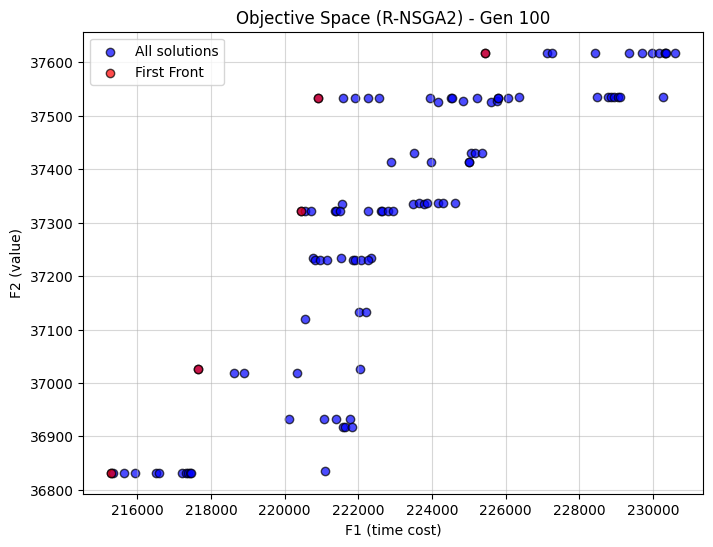

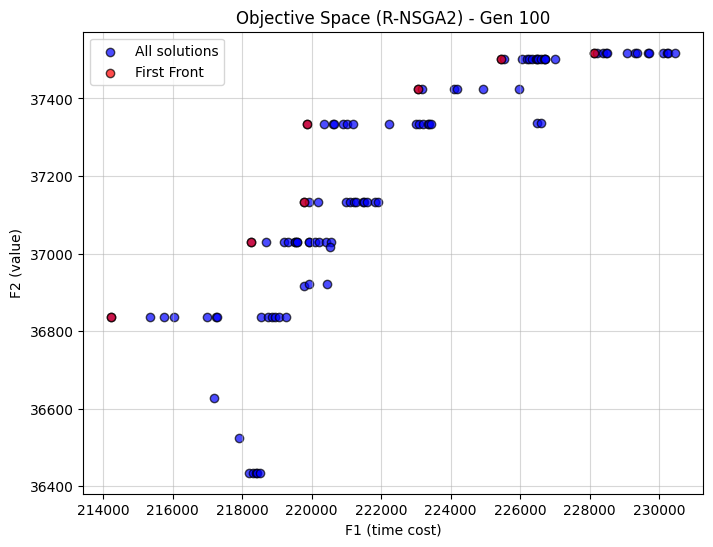

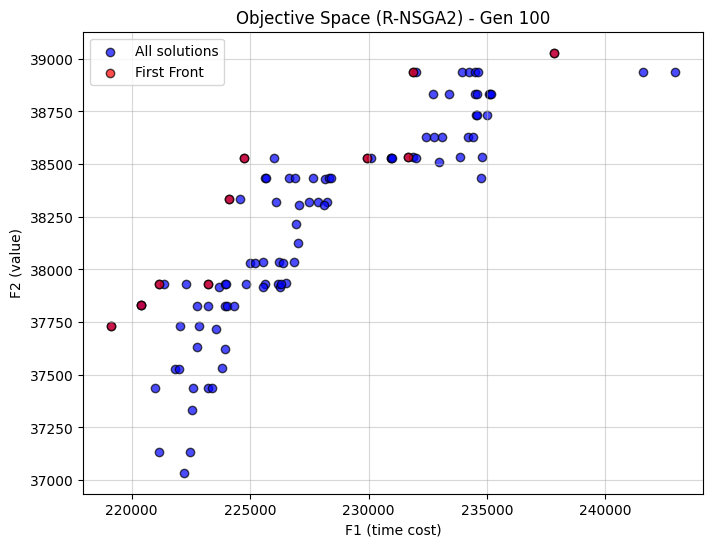

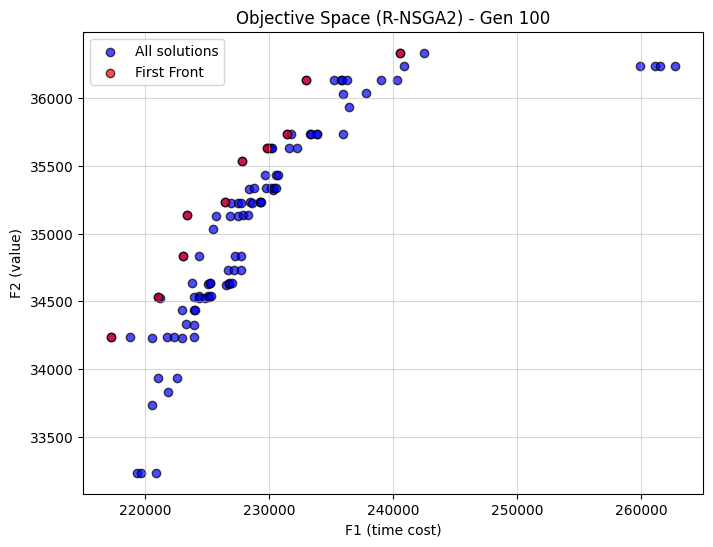

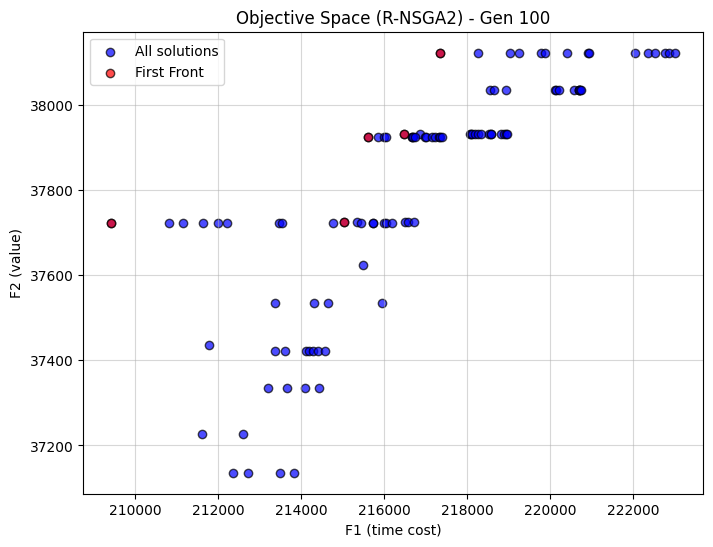

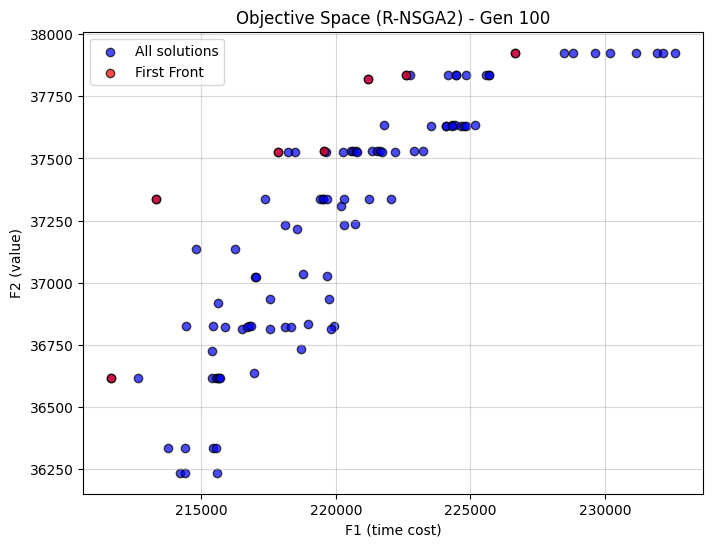

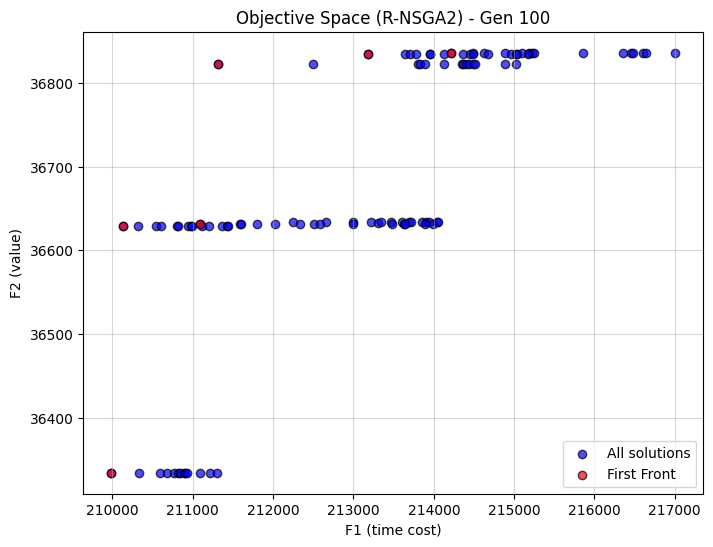

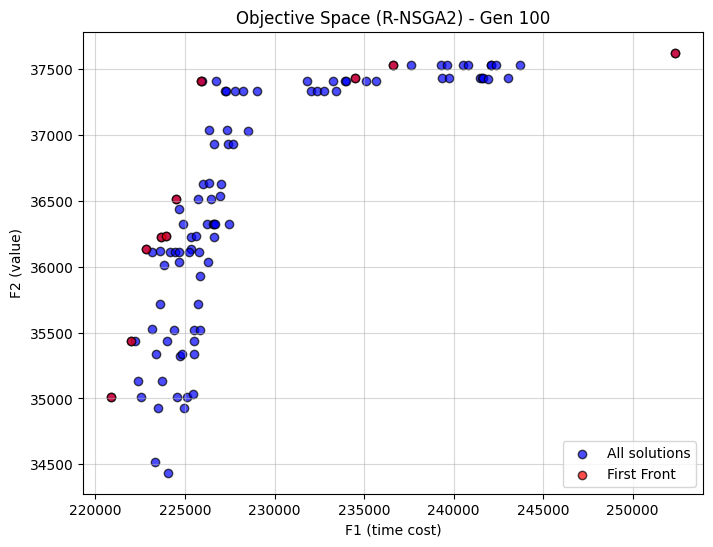

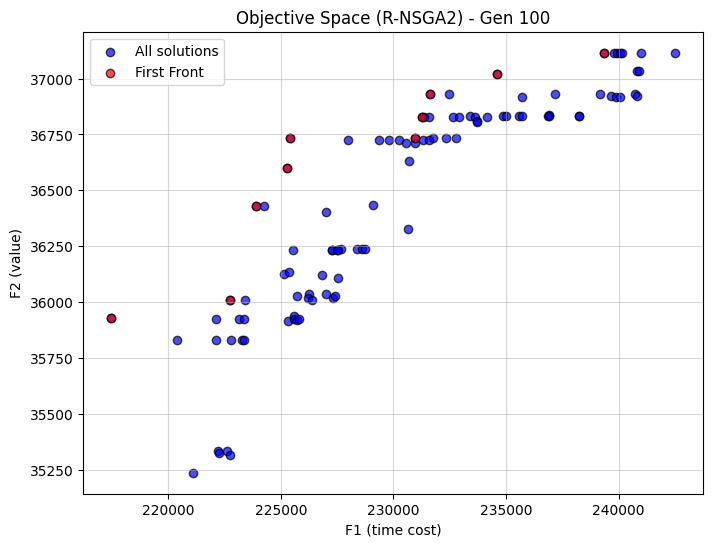

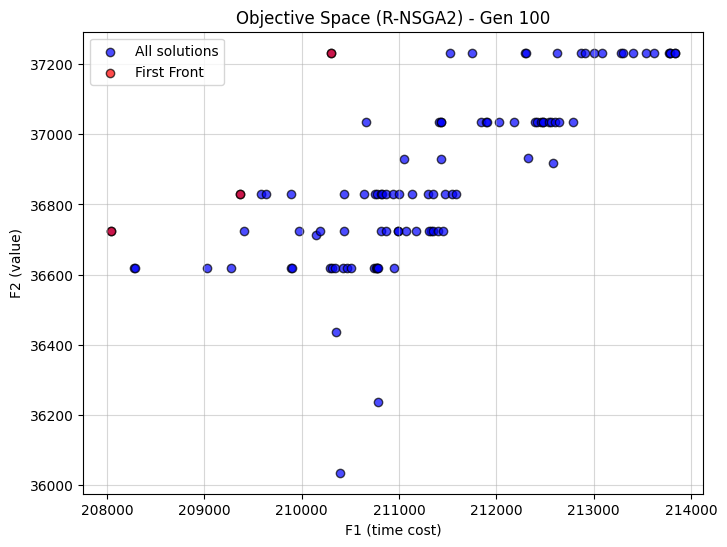

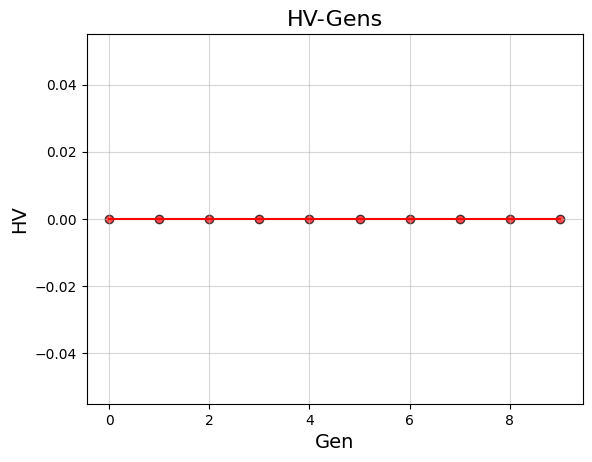

In [ ]:
from pymoo.indicators.hv import Hypervolume
import numpy as np
import random
import matplotlib.pyplot as plt

C = 1
file_name = 'a280-n279.txt'
# file_name = 'fnl4461-n4460.txt'
pop_size = 100
n_gens = 100
random_seed = 114514
reference_points = read_rp('HPI_a280-n279.f')
hv_point = np.array([5444.0, -0.0])  # Nadir Point
hv = Hypervolume(ref_point=hv_point)
HV = []
res = []

distance_matrix, items, cities_count, items_count = read_ttp_data(file_name)
capacity = np.sum(items[:, 2]) * (C/11)
path, selections = generate_initial_solutions(pop_size, cities_count, items_count, items, C, random_seed)

plt.figure(figsize=(8, 6))
for i in range(10):
  res_pop = R_NSGA2(
    pop_size = pop_size,
    n_gens = n_gens,
    reference_points = reference_points,
    cities_count = cities_count,
    items_count = items_count,
    items = items,
    C = C,
    random_seed = random_seed,
    distance_matrix = distance_matrix,
    path = path,
    selections = selections,)
  HV.append(hv.do(res_pop[2]))
  res.append(res_pop)
  random_seed += 1



plt.scatter(range(len(HV)), HV, c='r', edgecolors='k', alpha=0.7, label = 'HV')
plt.plot(HV, c='r')

plt.title("HV-Gens", fontsize=16)
plt.xlabel("Gen", fontsize=14)
plt.ylabel("HV", fontsize=14)
plt.grid(alpha=0.5)
plt.show()

In [ ]:
print(res[0])
print(res[2])

[[243 137 164 ... 135 240 279]
 [212 190 113 ...  24 275 259]
 [226 225 171 ... 154 101 220]
 ...
 [226 225 171 ...  97 254  16]
 [226 225 171 ...  66 276 149]
 [226 225 171 ... 161 168  51]]
[[  93635.81325225 -248604.        ]
 [  95912.47316554 -255630.        ]
 [ 105244.11833989 -262119.        ]
 [  95181.39234088 -253660.        ]
 [ 105644.75381205 -265427.        ]
 [  98408.57900009 -257881.        ]
 [  94650.15741793 -251104.        ]
 [ 126853.95852364 -266112.        ]
 [  99996.03407171 -257910.        ]
 [ 102207.2787072  -260377.        ]
 [ 100850.52705709 -259817.        ]]


### RNSGA2（贪心机制生成路径初始解）

<Figure size 800x600 with 0 Axes>

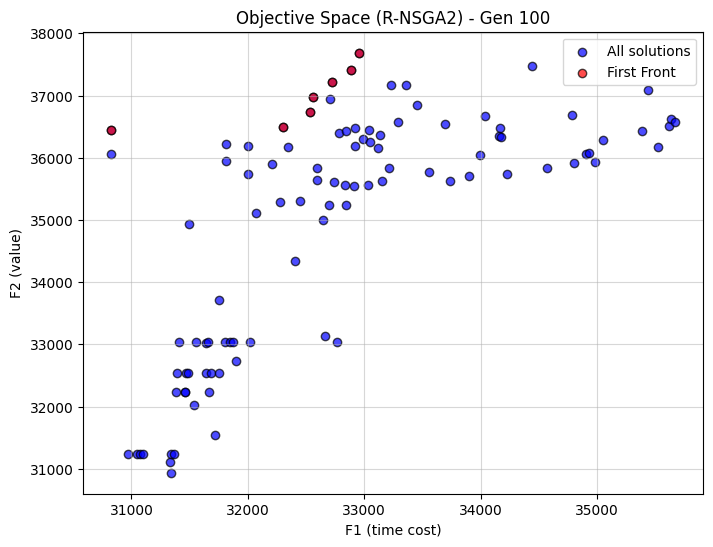

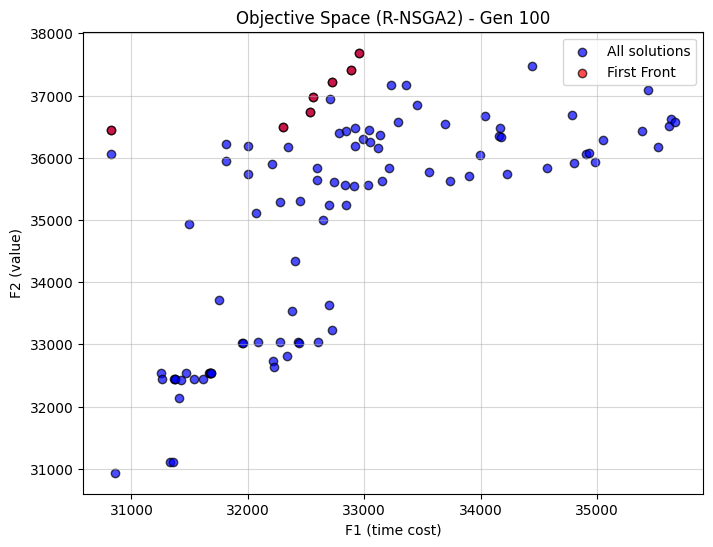

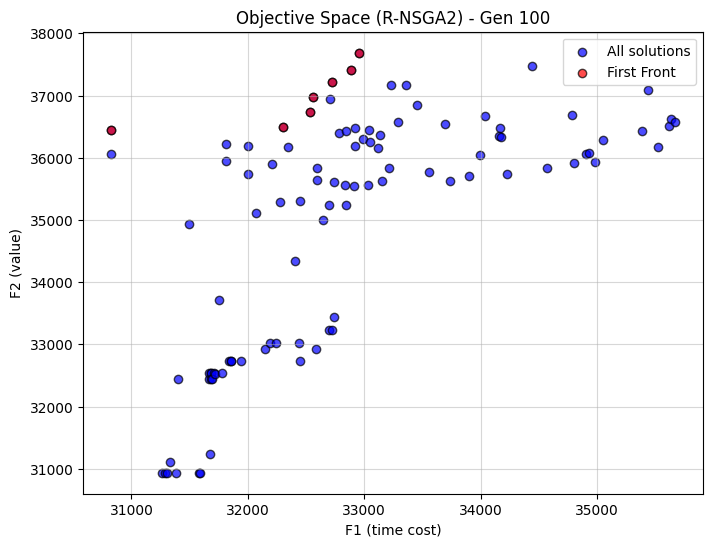

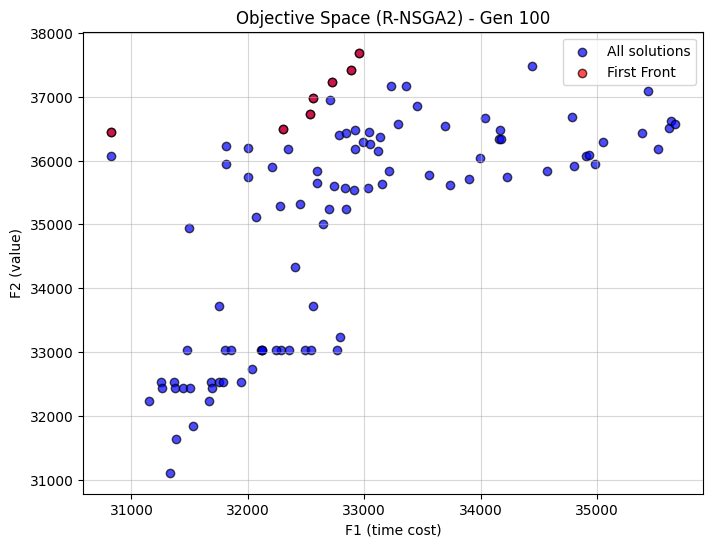

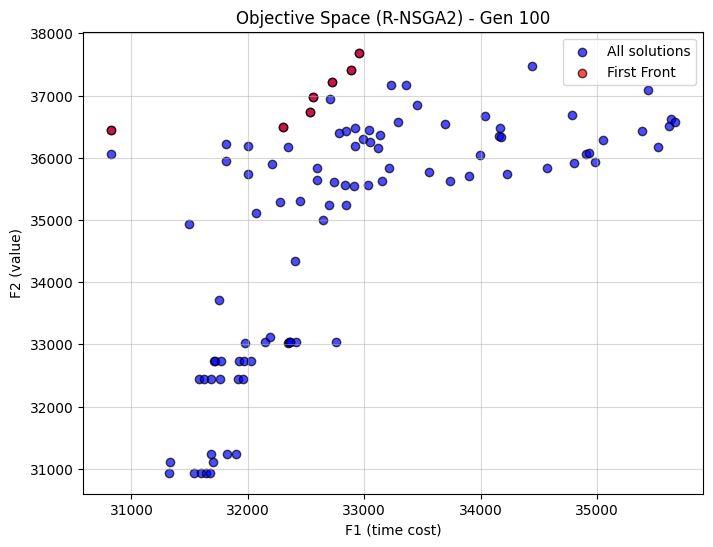

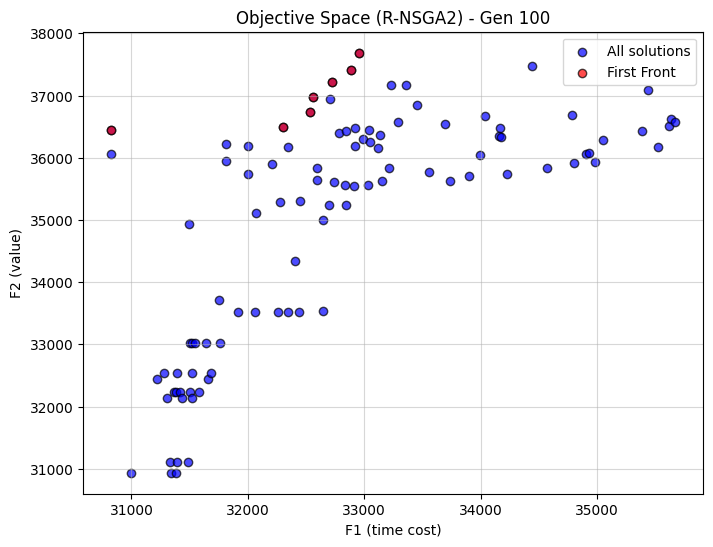

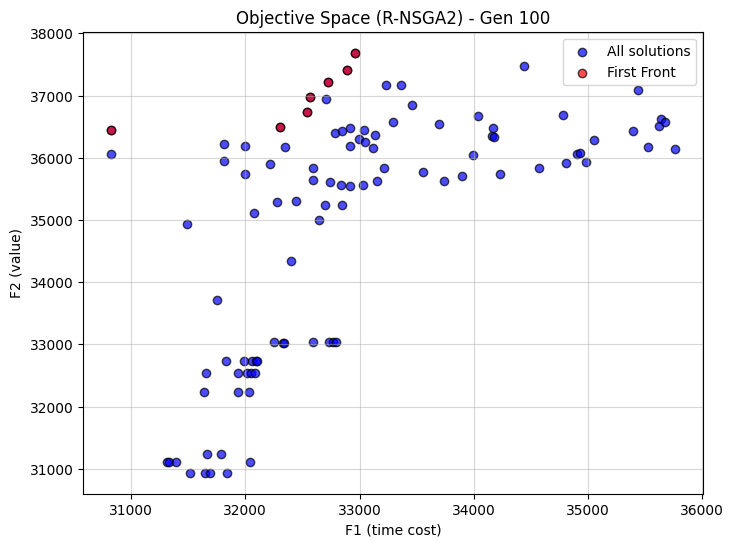

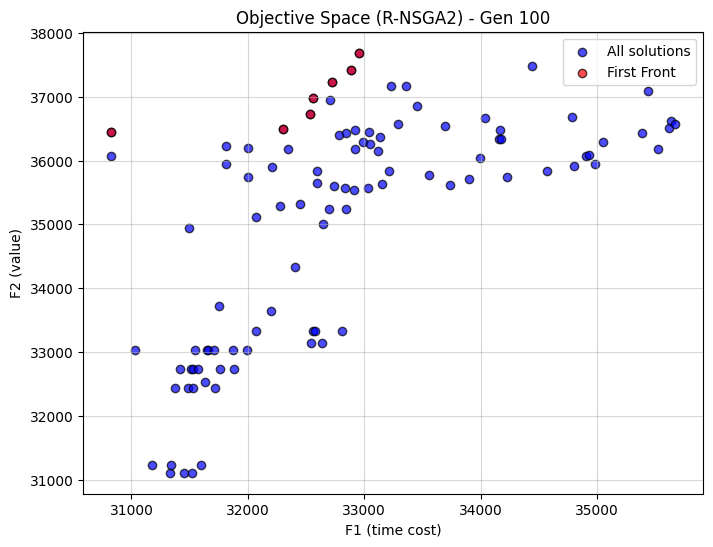

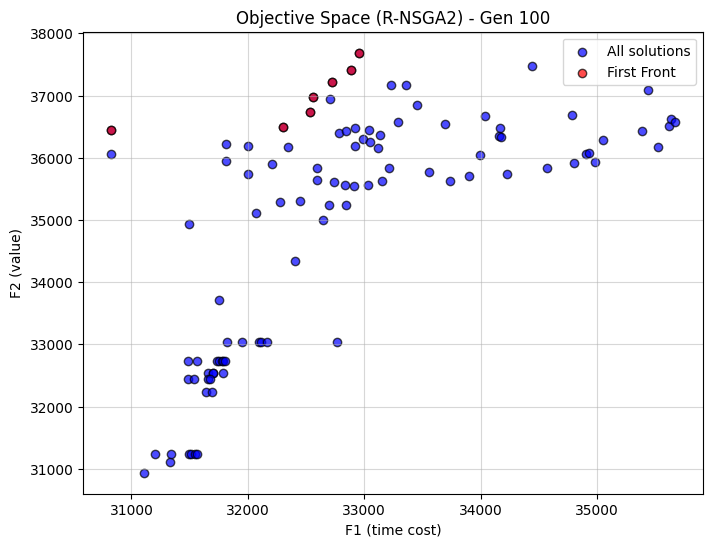

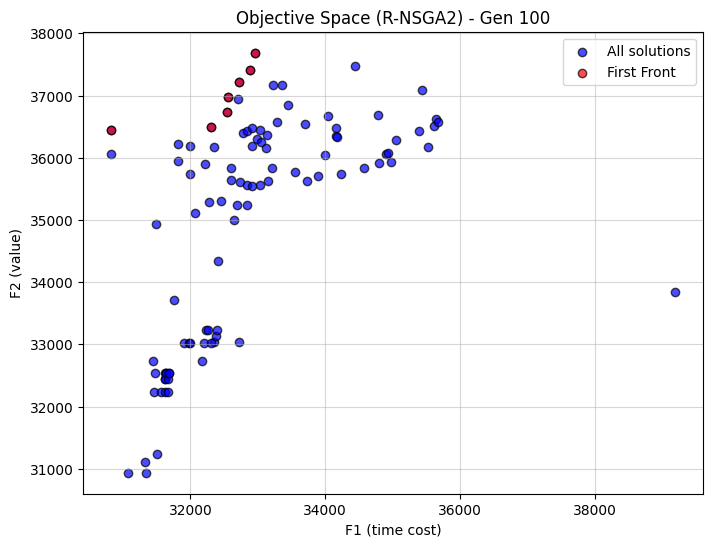

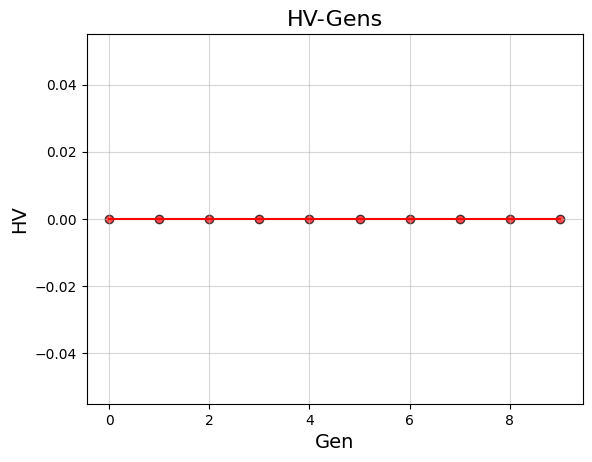

In [ ]:
from pymoo.indicators.hv import Hypervolume
import numpy as np
import random
import matplotlib.pyplot as plt

C = 1
file_name = 'a280-n279.txt'
# file_name = 'fnl4461-n4460.txt'
pop_size = 100
n_gens = 100
random_seed = 114514
reference_points = read_rp('HPI_a280-n279.f')
hv_point = np.array([5444.0, -0.0])  # Nadir Point
hv = Hypervolume(ref_point=hv_point)
HV = []
res_2 = []


distance_matrix, items, cities_count, items_count = read_ttp_data(file_name)
capacity = np.sum(items[:, 2]) * (C/11)

path, selections = generate_initial_solutions(pop_size, cities_count, items_count, items, C, distance_matrix, random_seed)


plt.figure(figsize=(8, 6))
for i in range(10):
  res_pop = R_NSGA2(
      pop_size = pop_size,
      n_gens = n_gens,
      reference_points = reference_points,
      cities_count = cities_count,
      items_count = items_count,
      items = items,
      C = C,
      distance_matrix = distance_matrix,
      path = path,
      selections = selections,
      random_seed = random_seed)
  HV.append(hv.do(res_pop[2]))
  res_2.append(res_pop)
  random_seed += 1


plt.scatter(range(len(HV)), HV, c='r', edgecolors='k', alpha=0.7, label = 'HV')
plt.plot(HV, c='r')

plt.title("HV-Gens", fontsize=16)
plt.xlabel("Gen", fontsize=14)
plt.ylabel("HV", fontsize=14)
plt.grid(alpha=0.5)
plt.show()

In [ ]:
print(selections.shape)
print(items[:, 0])

(100, 279)
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 239 240 241 242 243 244

In [ ]:
# print(res[0][2])
print(res_2[0][2])

[[232183.50453403 -37528.        ]
 [233434.02973936 -37634.        ]
 [230912.03078688 -37434.        ]
 [224865.29353249 -36702.        ]
 [226072.82140348 -37202.        ]
 [225991.72751284 -37030.        ]
 [227492.14458707 -37419.        ]
 [236858.48269637 -37721.        ]
 [233434.02973936 -37634.        ]
 [243150.4513842  -37821.        ]]
[[ 32957.16447179 -37689.        ]
 [ 32564.2313171  -36979.        ]
 [ 32306.78933485 -36491.        ]
 [ 32724.89044599 -37226.        ]
 [ 32537.71812367 -36736.        ]
 [ 30827.4802946  -36453.        ]
 [ 32887.88810145 -37418.        ]]


### RNSGA2_v3 （加入交叉率与变异率参数）

<Figure size 800x600 with 0 Axes>

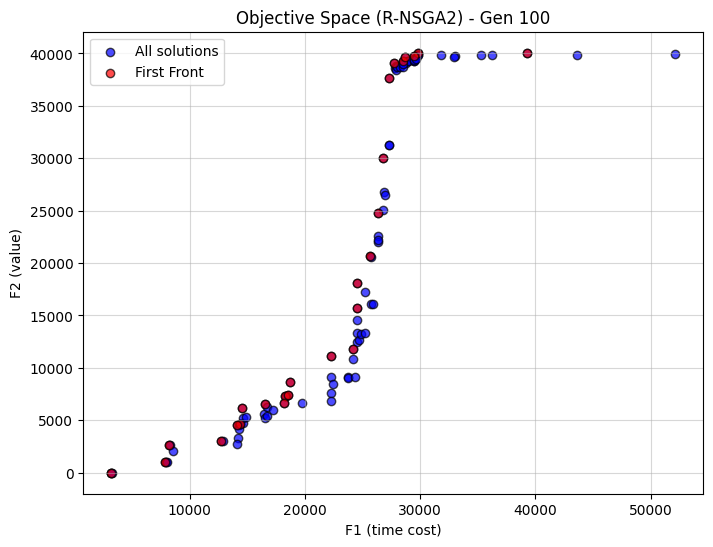

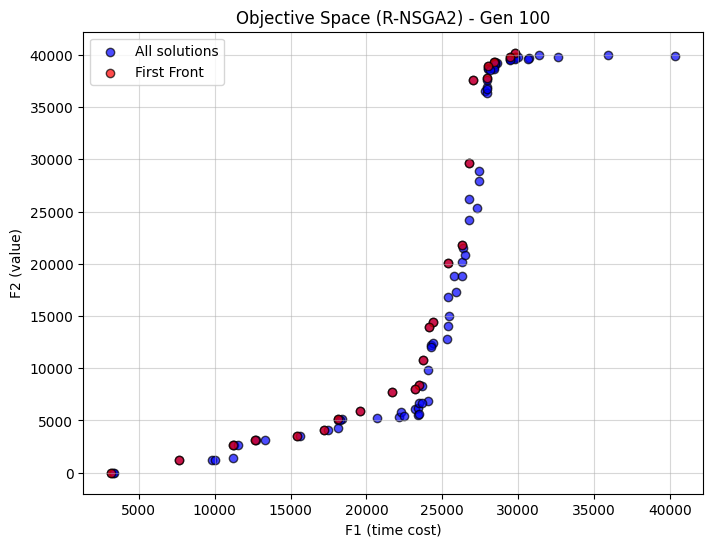

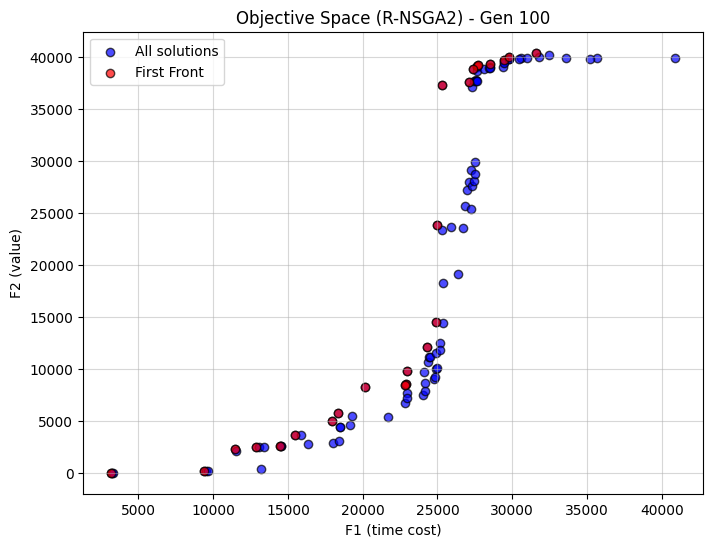

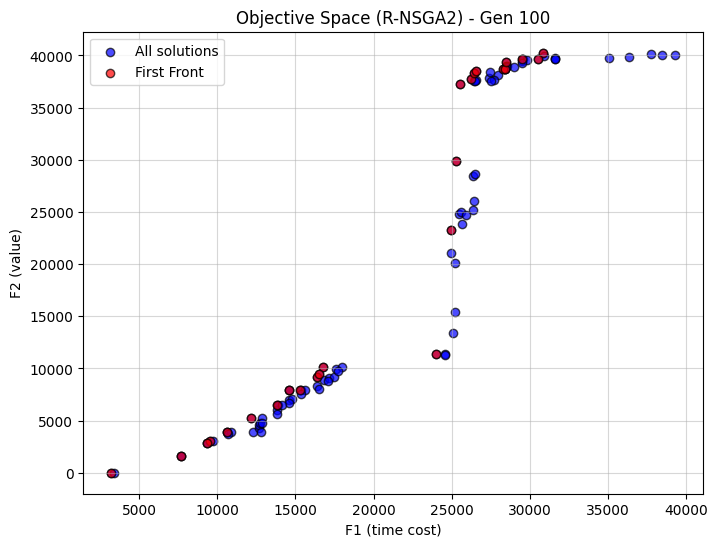

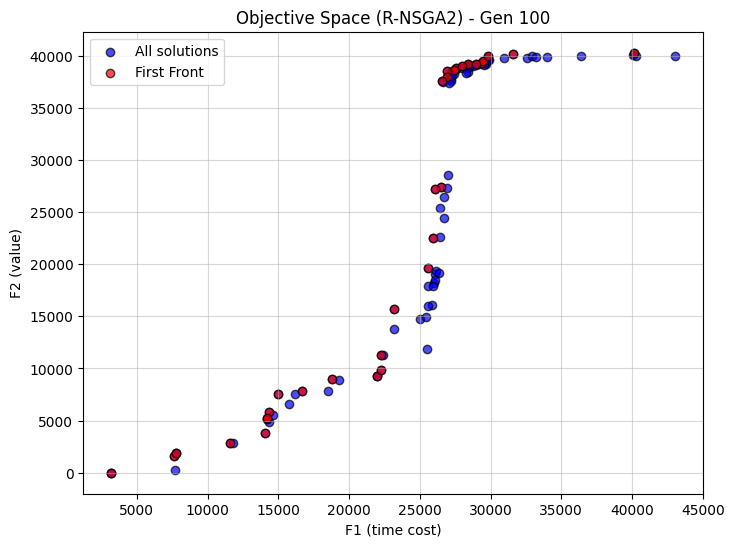

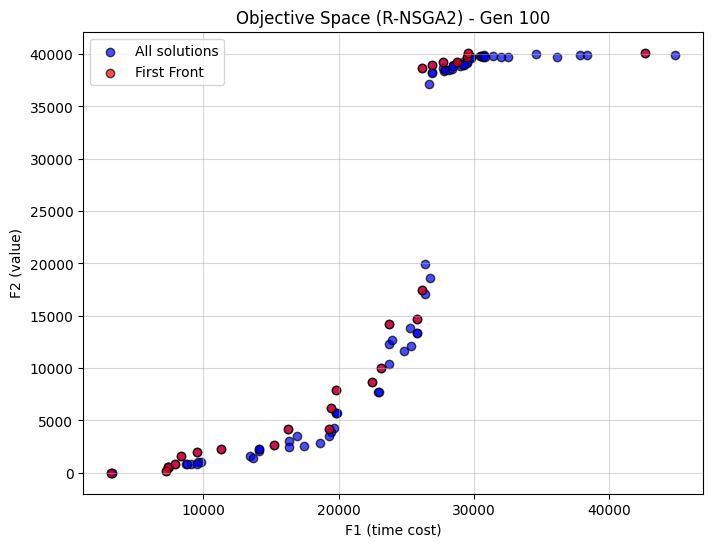

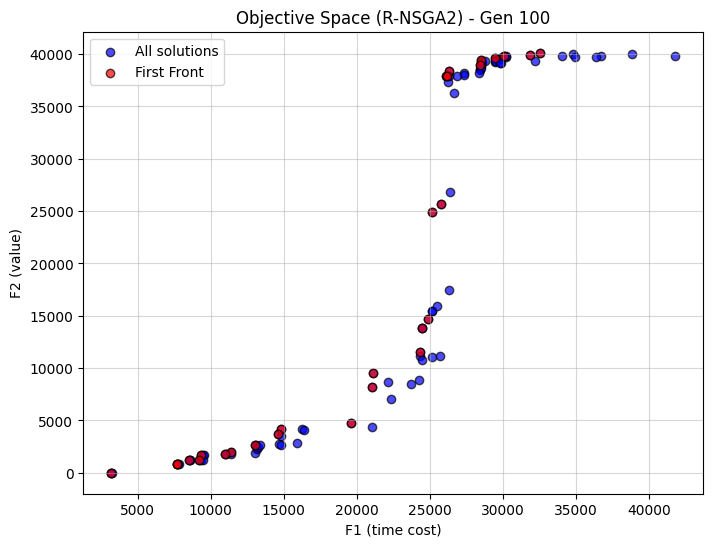

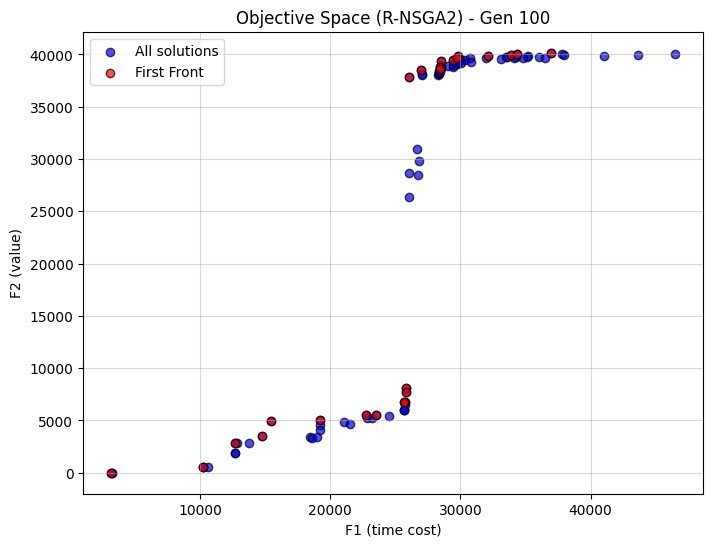

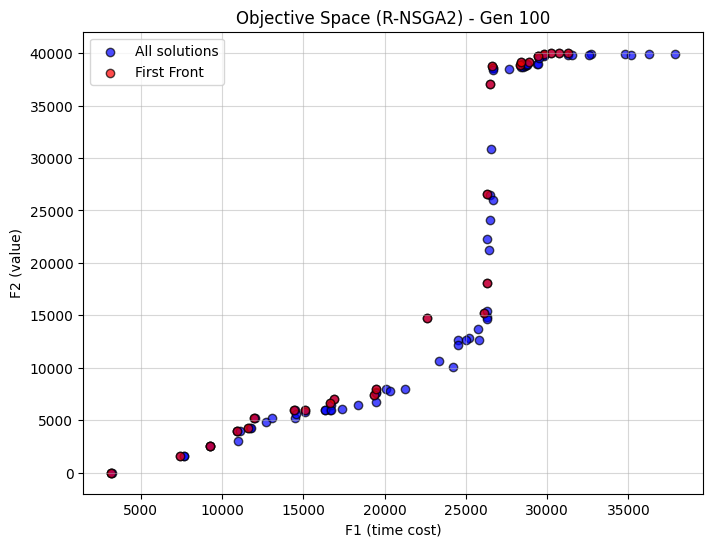

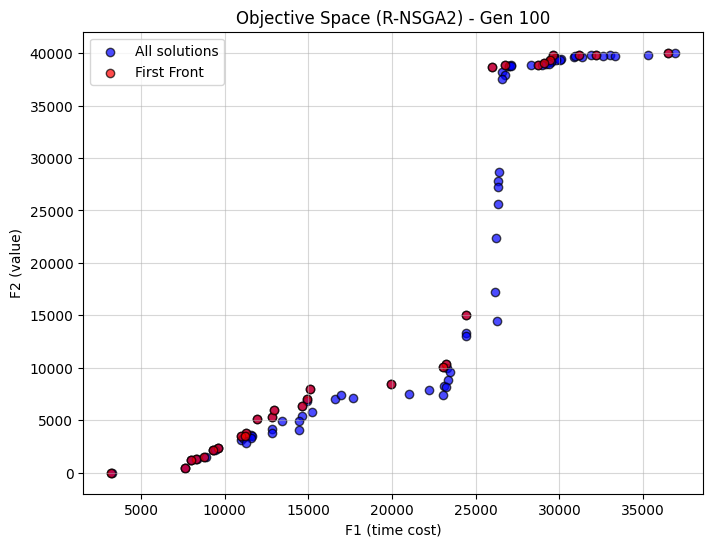

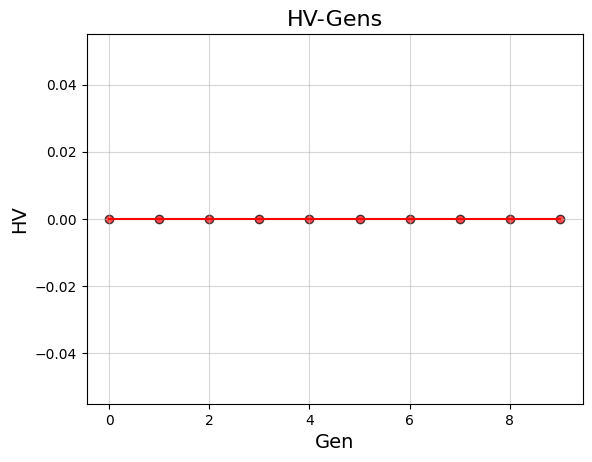

In [ ]:
from pymoo.indicators.hv import Hypervolume
import numpy as np
import random
import matplotlib.pyplot as plt

C = 1
file_name = 'a280-n279.txt'
# file_name = 'fnl4461-n4460.txt'
pop_size = 100
n_gens = 100
random_seed = 114514
reference_points = read_rp('HPI_a280-n279.f')
hv_point = np.array([5444.0, -0.0])  # Nadir Point
hv = Hypervolume(ref_point=hv_point)
HV = []
res_3 = []


distance_matrix, items, cities_count, items_count = read_ttp_data(file_name)
capacity = np.sum(items[:, 2]) * (C/11)

initial_path, initial_selections = generate_initial_solutions(pop_size, cities_count, items_count, items, C, distance_matrix, random_seed)


plt.figure(figsize=(8, 6))
for i in range(10):
  res_pop = R_NSGA2(
      pop_size = pop_size,
      n_gens = n_gens,
      reference_points = reference_points,
      cities_count = cities_count,
      items_count = items_count,
      items = items,
      C = C,
      distance_matrix = distance_matrix,
      path = initial_path,
      selections = initial_selections,
      random_seed = random_seed,
      cross_rate = 0.8,
      mut_rate = 0.3)
  HV.append(hv.do(res_pop[2]))
  res_3.append(res_pop)
  random_seed += 1


plt.scatter(range(len(HV)), HV, c='r', edgecolors='k', alpha=0.7, label = 'HV')
plt.plot(HV, c='r')

plt.title("HV-Gens", fontsize=16)
plt.xlabel("Gen", fontsize=14)
plt.ylabel("HV", fontsize=14)
plt.grid(alpha=0.5)
plt.show()

In [ ]:
import requests
import numpy as np

def read_ttp_data(filename):
    """
    读取TTP问题数据文件
    参数:
        filename: str, 文件名 (例如: 'a280-n279.txt')
    返回:
        distance_matrix: np.array, 城市间距离矩阵
        items: np.array, 物品信息 [序号, 利润, 重量, 所在城市编号]
        dimension: int, 城市数量
        items_count: int, 物品数量
    """
    # 构建GitHub原始文件URL
    base_url = "https://raw.githubusercontent.com/blankjul/gecco19-thief/master/src/main/resources/"
    url = base_url + filename

    # 下载数据文件
    response = requests.get(url)
    if response.status_code != 200:
        raise Exception(f"无法下载文件 {filename}")

    data = response.text.strip().split('\n')

    # 解析数据
    dimension = 0
    items_count = 0
    coordinates = []
    items = []

    reading_coords = False
    reading_items = False

    for line in data:
        if "DIMENSION" in line:
            dimension = int(line.split()[-1])
        elif "NUMBER OF ITEMS" in line:
            items_count = int(line.split()[-1])
        elif "NODE_COORD_SECTION" in line:
            reading_coords = True
            reading_items = False
            continue
        elif "ITEMS SECTION" in line:
            reading_coords = False
            reading_items = True
            continue

        if reading_coords:
            _, x, y = map(float, line.split())
            coordinates.append([x, y])
        elif reading_items:
            if line.strip() and not line.startswith("EOF"):
                item_id, profit, weight, node = map(int, line.split())
                # 添加物品序号作为第一列，节点编号从0开始
                items.append([item_id, profit, weight, node])

    # 转换为numpy数组
    coordinates = np.array(coordinates)
    items = np.array(items)

    # 计算城市间距离矩阵
    distance_matrix = np.zeros((dimension, dimension))
    for i in range(dimension):
        for j in range(dimension):
            if i != j:
                dx = coordinates[i][0] - coordinates[j][0]
                dy = coordinates[i][1] - coordinates[j][1]
                distance_matrix[i][j] = np.sqrt(dx*dx + dy*dy)

    # print(f"成功读取文件: {filename}")
    # print(f"城市数量: {dimension}")
    # print(f"物品数量: {items_count}")
    # print(f"距离矩阵形状: {distance_matrix.shape}")
    # print(f"物品信息形状: {items.shape}")
    # print(f"物品信息格式: [序号, 利润, 重量, 所在城市编号]")

    return distance_matrix, items, dimension, items_count

# 使用示例
# distance_matrix, items, dimension, items_count = read_ttp_data('a280-n279.txt')


In [ ]:
distance_matrix, items, cities_count, items_count = read_ttp_data('a280-n1395.txt')
print(distance_matrix[:6, :6])
print(items[:10])
# print(items[:3, 2])

[[ 0.         20.         24.08318916 32.984845   32.984845   42.75511665]
 [20.          0.         18.43908891 34.17601498 42.52058325 50.47771786]
 [24.08318916 18.43908891  0.         16.1245155  27.78488798 33.9411255 ]
 [32.984845   34.17601498 16.1245155   0.         16.         18.86796226]
 [32.984845   42.52058325 27.78488798 16.          0.         10.        ]
 [42.75511665 50.47771786 33.9411255  18.86796226 10.          0.        ]]
[[   1    1 1008    2]
 [   2  896 1006    3]
 [   3  367 1006    4]
 [   4  690 1001    5]
 [   5  613 1006    6]
 [   6  874 1001    7]
 [   7  122 1009    8]
 [   8  486 1004    9]
 [   9  823 1001   10]
 [  10  463 1003   11]]


In [ ]:
import numpy as np
import requests

def read_rp(filename):

  # 下载数据文件的raw内容
  base_url = "https://raw.githubusercontent.com/blankjul/gecco19-thief/master/submissions/HPI/"
  url = base_url + filename

  rp_response = requests.get(url)

  # 将数据按行分割
  data = rp_response.text.splitlines()

  # 提取 x 和 y 值
  coordinates = []
  for line in data:
      # 忽略空行和非数据行
      if line.strip() == "" or line.startswith("#"):
          continue
      # 提取坐标值 (x, y)
      values = line.split()
      if len(values) >= 2:  # 确保有两个值
          x = float(values[0])
          y = -float(values[1])
          coordinates.append([x, y])
  return np.array(coordinates)

# 完善注释版RNSGA2算法框架（并非完善，TODO）

## RNSGA2_v1-v2(两者只改变了初始解生成方式)

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

# ============ 评估函数 (Evaluation Function) ============
# 输入:
# - pop_size: 种群大小 (Population size)
# - city_routes: 每个个体的路径 (Routes for each individual)
# - item_selections: 每个个体的物品选择矩阵 (Item selection matrix for each individual)
# - distance_matrix: 城市间的距离矩阵 (Distance matrix between cities)
# - items: 物品属性矩阵 (编号, 价值, 重量, 所属城市) (Items attribute matrix: ID, value, weight, city)
# - C: 最大载重 (Maximum capacity)
# 输出:
# - f1: 每个个体的总时间 (目标1: 最小化) (Total time for each individual, Objective 1: Minimize)
# - f2: 每个个体的负总价值 (目标2: 最小化) (Negative total value for each individual, Objective 2: Minimize)
def evaluate_function(pop_size, city_routes, item_selections, distance_matrix, items, C):
    f1 = np.zeros(pop_size)  # 初始化总时间 (Initialize total time)
    f2 = np.zeros(pop_size)  # 初始化负总价值 (Initialize negative total value)

    for i in range(pop_size):
        # 构造完整路径: 起点 -> 中间城市 -> 回到起点 (Construct full path: Start -> Intermediate cities -> Back to start)
        path_i = city_routes[i]
        full_path = np.concatenate(([0], path_i, [0]))

        current_speed = 1.0  # 当前速度 (Current speed)
        current_weight = 0.0  # 当前载重 (Current weight)
        total_time = 0.0  # 总时间 (Total time)
        total_value = 0.0  # 总价值 (Total value)

        for j in range(len(full_path) - 1):
            from_city = full_path[j]
            to_city = full_path[j + 1]

            # 找到此城市对应的物品 (通过掩码过滤) (Find items corresponding to this city using a mask)
            city_mask = (items[:, 3] == from_city)
            selected_mask = item_selections[i][items[:, 0] - 1] == 1
            chosen_here = items[city_mask & selected_mask]

            if len(chosen_here) > 0:
                current_weight += np.sum(chosen_here[:, 2])  # 累加物品重量 (Accumulate item weights)
                total_value += np.sum(chosen_here[:, 1])  # 累加物品价值 (Accumulate item values)

            # 根据载重更新速度 (Update speed based on weight)
            current_speed = max(0.1, 1.0 - (current_weight / C) * 0.9)

            # 计算路段时间 (Calculate travel time for this segment)
            dist = distance_matrix[from_city, to_city]
            total_time += dist / current_speed

        # 存储目标值 (Store objective values)
        f1[i] = total_time
        f2[i] = -total_value  # 转为负值便于最小化 (Convert to negative for minimization)

    return f1, f2


# ============ 快速非支配排序 (Fast Non-Dominated Sorting) ============
# 输入:
# - F: 个体的目标值矩阵 (Matrix of objective values for individuals, N x 2)
# 输出:
# - fronts: 前沿层索引列表 (List of front indices)
# - rank: 每个个体所属的前沿层级 (Rank of each individual)
def fast_non_dominated_sort(F):
    N = len(F)
    S = [[] for _ in range(N)]  # S[p]: 被 p 支配的解 (Solutions dominated by p)
    n = np.zeros(N, dtype=np.int32)  # n[q]: 支配 q 的解数量 (Number of solutions dominating q)
    rank = np.zeros(N, dtype=np.int32)  # rank[i]: 解 i 的层级 (Rank of solution i)

    # 按 F1 排序后剥离支配关系 (Sort by F1 and determine dominance)
    F1_sorted_indices = np.argsort(F[:, 0])
    for i in range(N - 1):
        p = F1_sorted_indices[i]
        for j in range(i + 1, N):
            q = F1_sorted_indices[j]
            if (F[p, 0] <= F[q, 0] and F[p, 1] < F[q, 1]) or \
               (F[p, 0] < F[q, 0] and F[p, 1] <= F[q, 1]):
                S[p].append(q)
                n[q] += 1
            elif (F[q, 0] <= F[p, 0] and F[q, 1] < F[p, 1]) or \
                 (F[q, 0] < F[p, 0] and F[q, 1] <= F[p, 1]):
                S[q].append(p)
                n[p] += 1

    # 确定第一前沿 (Identify the first front)
    front = [i for i in range(N) if n[i] == 0]
    for i in front:
        rank[i] = 0

    fronts = []
    i = 0
    while front:
        fronts.append(front)
        next_front = []
        for p in front:
            for q in S[p]:
                n[q] -= 1
                if n[q] == 0:
                    rank[q] = i + 1
                    next_front.append(q)
        i += 1
        front = next_front

    return fronts, rank


# ============ 拥挤距离计算 (Crowding Distance Calculation) ============
# 输入:
# - F: 个体的目标值矩阵 (Matrix of objective values for individuals)
# - front_indices: 当前前沿的索引列表 (Indices of the current front)
# 输出:
# - distances: 拥挤距离数组 (Array of crowding distances)
def crowding_distance(F, front_indices):
    l = len(front_indices)
    if l <= 2:
        return [float('inf')] * l

    distances = [0.0] * l
    for m in range(F.shape[1]):
        sorted_idx = sorted(range(l), key=lambda i: F[front_indices[i], m])
        distances[sorted_idx[0]] = float('inf')
        distances[sorted_idx[-1]] = float('inf')

        f_min = F[front_indices[sorted_idx[0]], m]
        f_max = F[front_indices[sorted_idx[-1]], m]
        denom = f_max - f_min if f_max > f_min else 1e-14

        for i in range(1, l - 1):
            left_idx = front_indices[sorted_idx[i - 1]]
            right_idx = front_indices[sorted_idx[i + 1]]
            distances[sorted_idx[i]] += (F[right_idx, m] - F[left_idx, m]) / denom

    return distances


# ============ 参考点距离计算 (Reference Point Distance Calculation) ============
# 输入:
# - front_F: 当前前沿的目标值矩阵 (Objective values for the current front)
# - reference_points: 参考点集合 (Set of reference points)
# 输出:
# - distances: 解到各参考点的距离矩阵 (Distance matrix from solutions to reference points)
def rp_calculation(front_F, reference_points):
    n_sol = len(front_F)
    n_ref = len(reference_points)
    distances = np.zeros((n_sol, n_ref))

    # 归一化处理目标值 (Normalize objective values)
    f1_min, f1_max = np.min(front_F[:, 0]), np.max(front_F[:, 0])
    f2_min, f2_max = np.min(front_F[:, 1]), np.max(front_F[:, 1])
    denom_f1 = f1_max - f1_min if f1_max > f1_min else 1e-14
    denom_f2 = f2_max - f2_min if f2_max > f2_min else 1e-14

    F_norm = np.zeros_like(front_F)
    F_norm[:, 0] = (front_F[:, 0] - f1_min) / denom_f1
    F_norm[:, 1] = (front_F[:, 1] - f2_min) / denom_f2

    # 计算到参考点的距离 (Compute distances to reference points)
    for i in range(n_sol):
        for j in range(n_ref):
            distances[i, j] = np.linalg.norm(F_norm[i] - reference_points[j])

    return distances

# ============ 锦标赛产生子代 (Tournament-Based Offspring Generation) ============
# 输入:
# - pop_size: 子代目标大小 (Target size of offspring)
# - path: 父代路径 (Parent generation paths)
# - selections: 父代物品选择 (Parent generation item selections)
# - capacity: 背包容量 (Knapsack capacity)
# - rank: 每个个体的前沿层级 (Rank of each individual)
# - cd_all: 拥挤距离 (Crowding distances)
# - items: 物品属性矩阵 (Items attribute matrix)
# - seen: 已生成的个体集合 (Set of already generated individuals)
# 输出:
# - offspring_path: 子代路径 (Offspring paths)
# - offspring_selections: 子代物品选择 (Offspring item selections)
# - seen: 更新后的已生成个体集合 (Updated set of already generated individuals)
def generate_children(pop_size, path, selections, capacity, rank, cd_all, items, seen):
    offspring_path = []
    offspring_selections = []
    total_individuals = len(path)

    while len(offspring_path) < pop_size:
        # 随机选2个个体进行锦标赛选择 (Randomly select 2 individuals for tournament selection)
        c1 = random.sample(range(total_individuals), 2)
        if rank[c1[0]] < rank[c1[1]]:
            p1 = c1[0]
        elif rank[c1[0]] > rank[c1[1]]:
            p1 = c1[1]
        else:
            p1 = c1[0] if cd_all[c1[0]] > cd_all[c1[1]] else c1[1]

        # 再选2个个体进行锦标赛选择 (Select another 2 individuals for tournament selection)
        c2 = random.sample(range(total_individuals), 2)
        if rank[c2[0]] < rank[c2[1]]:
            p2 = c2[0]
        elif rank[c2[0]] > rank[c2[1]]:
            p2 = c2[1]
        else:
            p2 = c2[0] if cd_all[c2[0]] > cd_all[c2[1]] else c2[1]

        # 交叉和变异生成子代 (Generate offspring through crossover and mutation)
        child_p, child_s = crossover_mutation(
            path[p1], selections[p1],
            path[p2], selections[p2],
            items, capacity
        )
        key = (tuple(child_p), tuple(child_s))

        # 确保子代唯一性 (Ensure uniqueness of offspring)
        if key not in seen:
            seen.add(key)
            offspring_path.append(child_p)
            offspring_selections.append(child_s)

    return np.array(offspring_path), np.array(offspring_selections), seen


# ============ OX交叉 + 简易装包 (OX Crossover + Simple Packing) ============
# 输入:
# - parent1_path: 父代1路径 (Path of parent 1)
# - parent1_sel: 父代1物品选择 (Item selection of parent 1)
# - parent2_path: 父代2路径 (Path of parent 2)
# - parent2_sel: 父代2物品选择 (Item selection of parent 2)
# - items: 物品属性矩阵 (Items attribute matrix)
# - capacity: 背包容量 (Knapsack capacity)
# 输出:
# - child_path: 子代路径 (Offspring path)
# - child_sel: 子代物品选择 (Offspring item selection)
def crossover_mutation(parent1_path, parent1_sel, parent2_path, parent2_sel, items, capacity):
    size = len(parent1_path)
    # 随机选择两个交叉点 (Randomly select two crossover points)
    point1, point2 = sorted(random.sample(range(size), 2))

    # OX交叉生成子路径 (Perform OX crossover to generate offspring path)
    child_path = np.zeros(size, dtype=np.int32)
    child_path[point1:point2] = parent1_path[point1:point2]

    remaining = [city for city in parent2_path if city not in child_path[point1:point2]]
    idx_rem = 0
    for i in range(size):
        if child_path[i] == 0:
            child_path[i] = remaining[idx_rem]
            idx_rem += 1

    # 简单装包策略: 按顺序尽可能装满 (Simple packing: Fill items sequentially up to capacity)
    child_sel = np.zeros(len(items), dtype=np.int32)
    current_weight = 0.0
    for city in child_path:
        item_indices = np.where(items[:, 3] == city)[0]
        for idx in item_indices:
            w = items[idx, 2]
            if current_weight + w <= capacity:
                child_sel[idx] = 1
                current_weight += w
            else:
                # 超出容量的物品不装 (Skip items exceeding capacity)
                pass

    return child_path, child_sel


# ============ 基于参考点的种群选择 (Reference-Point Based Population Selection) ============
# 输入:
# - fronts: 前沿分层结果 (Front layers)
# - F: 个体目标值矩阵 (Objective values of individuals)
# - pop_size: 种群大小 (Population size)
# - reference_points: 参考点集合 (Set of reference points)
# 输出:
# - selected_indices: 被选中的种群个体索引 (Indices of selected individuals)
def pop_selection(fronts, F, pop_size, reference_points):
    selected_indices = []
    remaining = pop_size
    last_front = None

    # 按层次逐步选取 (Iteratively select by layer)
    for front in fronts:
        if len(selected_indices) + len(front) < pop_size:
            selected_indices.extend(front)
            remaining = pop_size - len(selected_indices)
        elif len(selected_indices) + len(front) == pop_size:
            selected_indices.extend(front)
            remaining = 0
            break
        else:
            last_front = front
            break

    if remaining == 0 or last_front is None:
        return selected_indices

    # 对无法整层接纳的最后一层，按参考点分配 (Handle last layer using reference-point allocation)
    front_F = F[last_front]
    dist_mat = rp_calculation(front_F, reference_points)

    # 按参考点聚类 (Cluster by reference points)
    assignments = np.argmin(dist_mat, axis=1)
    clusters = [[] for _ in range(len(reference_points))]
    for i, global_idx in enumerate(last_front):
        ref_idx = assignments[i]
        clusters[ref_idx].append((global_idx, dist_mat[i, ref_idx]))

    # 簇内按距离升序排序 (Sort within clusters by distance)
    for c in clusters:
        c.sort(key=lambda x: x[1])

    # 从每个簇中轮流选取 (Iteratively select from clusters)
    while remaining > 0:
        any_selected = False
        for c in clusters:
            if c and remaining > 0:
                selected_indices.append(c[0][0])
                c.pop(0)
                remaining -= 1
                any_selected = True
                if remaining == 0:
                    break
        if not any_selected:
            break

    return selected_indices


# ============ 主循环 (Main Loop) ============
# 输入:
# - pop_size: 种群大小 (Population size)
# - n_gens: 最大迭代代数 (Number of generations)
# - reference_points: 参考点集合 (Set of reference points)
# - cities_count: 城市数量 (Number of cities)
# - items_count: 物品数量 (Number of items)
# - items: 物品属性矩阵 (Items attribute matrix)
# - C: 最大载重 (Maximum capacity)
# - random_seed: 随机种子 (Random seed)
# - distance_matrix: 距离矩阵 (Distance matrix)
# - path: 初始路径种群 (Initial population of paths)
# - selections: 初始物品选择种群 (Initial population of item selections)
# 输出:
# - best_paths: 第一前沿的路径 (Paths in the first front)
# - best_sels: 第一前沿的物品选择 (Item selections in the first front)
# - best_F: 第一前沿的目标值 (Objective values in the first front)
def R_NSGA2(pop_size, n_gens, reference_points,
            cities_count, items_count, items, C,
            random_seed, distance_matrix,
            path, selections):
    if random_seed is not None:
        random.seed(random_seed)
        np.random.seed(random_seed)

    capacity = np.sum(items[:, 2]) * (C / 11.0)  # 计算背包容量 (Calculate knapsack capacity)
    seen = set((tuple(path[i]), tuple(selections[i])) for i in range(pop_size))

    for gen in range(n_gens):
        # 评估种群适应度 (Evaluate population fitness)
        f1, f2 = evaluate_function(len(path), path, selections, distance_matrix, items, C)
        F = np.column_stack((f1, f2))

        # 非支配排序与拥挤距离计算 (Non-dominated sorting and crowding distance calculation)
        fronts, rank = fast_non_dominated_sort(F)
        cd_all = np.zeros(len(path))
        for fr in fronts:
            cd_front = crowding_distance(F, fr)
            for i, idx in enumerate(fr):
                cd_all[idx] = cd_front[i]

        # 生成子代 (Generate offspring)
        child_path, child_selections, seen = generate_children(
            pop_size, path, selections, capacity, rank, cd_all, items, seen
        )

        # 合并种群并选择 (Merge populations and select)
        path = np.vstack((path, child_path))
        selections = np.vstack((selections, child_selections))
        f1, f2 = evaluate_function(len(path), path, selections, distance_matrix, items, C)
        F = np.column_stack((f1, f2))
        fronts, rank = fast_non_dominated_sort(F)
        chosen = pop_selection(fronts, F, pop_size, reference_points)

        path = path[chosen]
        selections = selections[chosen]

    # 返回第一前沿 (Return the first front)
    f1, f2 = evaluate_function(len(path), path, selections, distance_matrix, items, C)
    F = np.column_stack((f1, f2))
    final_fronts, _ = fast_non_dominated_sort(F)
    best_paths = path[final_fronts[0]]
    best_sels = selections[final_fronts[0]]
    best_F = F[final_fronts[0]]
    return best_paths, best_sels, best_F


## RNSGA2_v3_opt

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

# ============ 评估函数 (Evaluation Function) ============
# 计算种群中每个个体的两个目标值:
# f1: 总时间 (需最小化) - Total time (to be minimized)
# f2: -总价值 (负值便于最小化) - Negative total value (to be minimized)
def evaluate_function(pop_size, city_routes, item_selections, distance_matrix, items, C):
    """
    Args:
        pop_size: 种群大小 (Population size)
        city_routes: 城市路径种群 (Population of city routes)
        item_selections: 物品选择种群 (Population of item selections)
        distance_matrix: 城市距离矩阵 (Matrix of distances between cities)
        items: 物品属性矩阵 (Matrix of item attributes)
        C: 最大载重量 (Maximum capacity)

    Returns:
        f1: 每个个体的总时间 (Total time for each individual)
        f2: 每个个体的负总价值 (Negative total value for each individual)
    """
    f1 = np.zeros(pop_size)
    f2 = np.zeros(pop_size)

    # 预计算每个城市的物品索引 (Precompute item indices for each city)
    city_items = {}
    for i in range(len(items)):
        city = items[i, 3]
        if city not in city_items:
            city_items[city] = []
        city_items[city].append(i)

    for i in range(pop_size):
        path_i = city_routes[i]
        full_path = np.concatenate(([0], path_i, [0]))

        current_speed = 1.0
        current_weight = 0.0
        total_time = 0.0
        total_value = 0.0

        # 预计算选中的物品 (Precompute selected items)
        selected_items = np.where(item_selections[i] == 1)[0]
        selected_set = set(selected_items)

        for j in range(len(full_path) - 1):
            from_city = full_path[j]
            to_city = full_path[j + 1]

            # 查找在当前城市选中的物品 (Find selected items at the current city)
            if from_city in city_items:
                city_items_indices = city_items[from_city]
                chosen_here = []
                for idx in city_items_indices:
                    if idx in selected_set:
                        chosen_here.append(items[idx])
                if chosen_here:
                    chosen_here = np.array(chosen_here)
                    current_weight += np.sum(chosen_here[:, 2])  # 更新载重 (Update weight)
                    total_value += np.sum(chosen_here[:, 1])     # 更新总价值 (Update total value)

            # 根据载重调整速度 (Adjust speed based on weight)
            current_speed = max(0.1, 1.0 - (current_weight / C) * 0.9)
            dist = distance_matrix[from_city, to_city]
            total_time += dist / current_speed  # 累积时间 (Accumulate time)

        f1[i] = total_time
        f2[i] = -total_value  # 负值便于最小化 (Negative value for minimization)

    return f1, f2


# ============ 快速非支配排序 (Fast Non-Dominated Sorting) ============
def fast_non_dominated_sort(F):
    """
    对于目标值 F (N x 2), 返回 fronts (多层前沿的索引列表) 和 rank (每个个体的层级).
    对支配关系判断进行了优化，仅遍历半个矩阵。

    Args:
        F: 每个个体的目标值矩阵 (Matrix of objective values for each individual)

    Returns:
        fronts: 多层前沿索引列表 (List of indices for each front)
        rank: 每个个体的前沿层级 (Rank of each individual)
    """
    N = len(F)
    S = [[] for _ in range(N)]  # 被支配个体集合 (Set of solutions dominated by solution p)
    n = np.zeros(N, dtype=np.int32)  # 支配该解的个体数量 (Number of solutions dominating solution p)
    rank = np.zeros(N, dtype=np.int32)  # 每个解的非支配等级 (Non-dominated rank for each solution)

    # 预排序以加速支配关系计算 (Sort to accelerate domination calculation)
    F1_sorted_indices = np.argsort(F[:, 0])

    for i in range(N - 1):
        p = F1_sorted_indices[i]
        p_values = F[p]
        q_indices = F1_sorted_indices[i + 1:]
        q_values = F[q_indices]

        # 向量化支配关系判断 (Vectorized domination checking)
        p_dominates = ((p_values[0] <= q_values[:, 0]) & (p_values[1] < q_values[:, 1])) | \
                      ((p_values[0] < q_values[:, 0]) & (p_values[1] <= q_values[:, 1]))
        q_dominates = ((q_values[:, 0] <= p_values[0]) & (q_values[:, 1] < p_values[1])) | \
                      ((q_values[:, 0] < p_values[0]) & (q_values[:, 1] <= p_values[1]))

        for idx, q in enumerate(q_indices):
            if p_dominates[idx]:
                S[p].append(q)
                n[q] += 1
            elif q_dominates[idx]:
                S[q].append(p)
                n[p] += 1

    # 确定第一前沿 (Determine the first front)
    front = np.where(n == 0)[0].tolist()
    fronts = [front]
    i = 0

    while front:
        next_front = []
        for p in front:
            for q in S[p]:
                n[q] -= 1
                if n[q] == 0:
                    rank[q] = i + 1
                    next_front.append(q)
        i += 1
        front = next_front
        if front:
            fronts.append(front)

    return fronts, rank


# ============ 拥挤距离 (Crowding Distance) ============
def crowding_distance(F, front_indices):
    """
    针对某一前沿计算拥挤距离，用于维持种群多样性。
    对两个目标值分别计算贡献。

    Args:
        F: 个体目标值矩阵 (Matrix of objective values)
        front_indices: 当前前沿个体的索引 (Indices of individuals in the current front)

    Returns:
        distances: 拥挤距离列表 (List of crowding distances)
    """
    l = len(front_indices)
    if l <= 2:
        return [float('inf')] * l

    distances = np.zeros(l)
    front_F = F[front_indices]

    for m in range(F.shape[1]):
        sorted_idx = np.argsort(front_F[:, m])
        distances[sorted_idx[0]] = float('inf')
        distances[sorted_idx[-1]] = float('inf')

        f_range = front_F[sorted_idx[-1], m] - front_F[sorted_idx[0], m]
        if f_range == 0:
            f_range = 1e-14

        for i in range(1, l - 1):
            distances[sorted_idx[i]] += (front_F[sorted_idx[i + 1], m] - front_F[sorted_idx[i - 1], m]) / f_range

    return distances
# ============ 参考点距离计算 (Reference Point Distance Calculation) ============
def rp_calculation(front_F, reference_points):
    """
    对最后一层前沿的个体计算到各参考点的欧几里得距离，用于多样性选择。
    Perform min-max normalization for solutions in the last front and calculate their Euclidean
    distances to reference points.

    Args:
        front_F: 当前前沿的目标值 (Objective values of the current front)
        reference_points: 参考点坐标 (Coordinates of reference points)

    Returns:
        dist_mat: 每个解到各个参考点的距离矩阵 (Matrix of distances between solutions and reference points)
    """
    F_min = np.min(front_F, axis=0)
    F_max = np.max(front_F, axis=0)
    denom = np.maximum(F_max - F_min, 1e-14)
    F_norm = (front_F - F_min) / denom

    # 计算距离矩阵 (Compute distance matrix)
    dist_mat = np.sqrt(np.sum((F_norm[:, np.newaxis, :] - reference_points) ** 2, axis=2))
    return dist_mat


# ============ 锦标赛产生子代 (Generate Offspring Using Tournament Selection) ============
def generate_children(pop_size, path, selections, capacity, rank, cd_all, items, distance_matrix, C, cross_rate, mut_rate, seen):
    """
    以锦标赛选择和交叉/变异操作产生子代个体。
    Generate offspring using tournament selection and crossover/mutation operations.

    Args:
        pop_size: 种群大小 (Population size)
        path: 当前种群的路径 (Current population paths)
        selections: 当前种群的选择方案 (Current population item selections)
        capacity: 背包容量 (Knapsack capacity)
        rank: 当前种群的支配等级 (Dominance rank of the current population)
        cd_all: 拥挤距离 (Crowding distances of the current population)
        items: 物品属性 (Attributes of items)
        distance_matrix: 距离矩阵 (Distance matrix between cities)
        C: 最大载重量 (Maximum capacity)
        cross_rate: 交叉概率 (Crossover probability)
        mut_rate: 变异概率 (Mutation probability)
        seen: 已生成的个体集合 (Set of already generated individuals)

    Returns:
        offspring_path: 子代路径种群 (Paths of offspring)
        offspring_selections: 子代选择种群 (Selections of offspring)
        seen: 更新后的已生成个体集合 (Updated set of generated individuals)
    """
    offspring_path = []
    offspring_selections = []
    total_individuals = len(path)

    tournament_pairs_idx = 0
    cross_decisions_idx = 0
    mut_decisions_idx = 0

    tournament_pairs = np.random.randint(0, total_individuals, (1000, 2))
    cross_decisions = np.random.random(1000) < cross_rate
    mut_decisions = np.random.random(1000) < mut_rate

    while len(offspring_path) < pop_size:
        if tournament_pairs_idx >= len(tournament_pairs):
            tournament_pairs = np.random.randint(0, total_individuals, (1000, 2))
            tournament_pairs_idx = 0
        if cross_decisions_idx >= len(cross_decisions):
            cross_decisions = np.random.random(1000) < cross_rate
            cross_decisions_idx = 0
        if mut_decisions_idx >= len(mut_decisions):
            mut_decisions = np.random.random(1000) < mut_rate
            mut_decisions_idx = 0

        c1 = tournament_pairs[tournament_pairs_idx]
        c2 = tournament_pairs[(tournament_pairs_idx + 1) % len(tournament_pairs)]
        tournament_pairs_idx += 2

        p1 = c1[0] if (rank[c1[0]] < rank[c1[1]] or
                      (rank[c1[0]] == rank[c1[1]] and cd_all[c1[0]] > cd_all[c1[1]])) else c1[1]
        p2 = c2[0] if (rank[c2[0]] < rank[c2[1]] or
                      (rank[c2[0]] == rank[c2[1]] and cd_all[c2[0]] > cd_all[c2[1]])) else c2[1]

        if cross_decisions[cross_decisions_idx]:
            child_p = crossover(path[p1], path[p2])
        else:
            child_p = sample_mutation(path[p1])
        cross_decisions_idx += 1

        if mut_decisions[mut_decisions_idx]:
            child_p = opt_mutation(child_p)
        mut_decisions_idx += 1

        if cross_decisions[cross_decisions_idx]:
            child_s = generate_selections_for_path(child_p, items, capacity, distance_matrix, C, mut_rate)
        else:
            child_s = selections[p1].copy()
            mut_mask = (child_s == 1) & (np.random.random(len(child_s)) < mut_rate)
            child_s[mut_mask] = 0
        cross_decisions_idx += 1

        key = (tuple(child_p.tolist()), tuple(child_s.tolist()))
        if key not in seen:
            seen.add(key)
            offspring_path.append(child_p)
            offspring_selections.append(child_s)

    return np.array(offspring_path), np.array(offspring_selections), seen


# ============ OX交叉 + 变异操作 (OX Crossover and Mutation Operations) ============
def crossover(parent1_path, parent2_path):
    """
    执行OX交叉操作产生子路径。
    Perform Order Crossover (OX) to generate child path.

    Args:
        parent1_path: 父路径1 (Path of parent 1)
        parent2_path: 父路径2 (Path of parent 2)

    Returns:
        child_path: 子路径 (Child path)
    """
    size = len(parent1_path)
    point1, point2 = sorted(np.random.choice(size, 2, replace=False))
    child_path = np.zeros(size, dtype=np.int32)
    child_path[point1:point2] = parent1_path[point1:point2]

    used = set(child_path[point1:point2])
    remaining = [city for city in parent2_path if city not in used]

    child_path[:point1] = remaining[:point1]
    child_path[point2:] = remaining[point1:]
    return child_path


def sample_mutation(path):
    """
    执行简单交换变异。
    Perform simple swap mutation.

    Args:
        path: 输入路径 (Input path)

    Returns:
        mutated_path: 变异后的路径 (Mutated path)
    """
    mutated_path = path.copy()
    pos1, pos2 = np.random.choice(len(path), 2, replace=False)
    mutated_path[pos1], mutated_path[pos2] = mutated_path[pos2], mutated_path[pos1]
    return mutated_path


def opt_mutation(path):
    """
    执行2-opt翻转变异。
    Perform 2-opt reversal mutation.

    Args:
        path: 输入路径 (Input path)

    Returns:
        mutated_path: 变异后的路径 (Mutated path)
    """
    size = len(path)
    i, j = sorted(np.random.choice(size, 2, replace=False))
    mutated_path = path.copy()
    mutated_path[i:j+1] = mutated_path[i:j+1][::-1]
    return mutated_path


def generate_selections_for_path(path, items, capacity, distance_matrix, C, mut_rate):
    """
    根据给定路径生成物品选择方案，同时考虑路径时间成本和变异率。
    Generate item selection based on the given path, considering time cost and mutation rate.

    Args:
        path: 输入路径 (Input path)
        items: 物品信息 (Item information)
        capacity: 背包容量 (Knapsack capacity)
        distance_matrix: 距离矩阵 (Distance matrix)
        C: 最大载重量 (Maximum capacity)
        mut_rate: 变异率 (Mutation rate)

    Returns:
        selections: 生成的物品选择方案 (Generated item selection)
    """
    n_items = len(items)
    selections = np.zeros(n_items, dtype=np.int32)
    full_path = np.concatenate(([0], path, [0]))

    city_items = {}
    for i in range(n_items):
        city = items[i, 3]
        if city not in city_items:
            city_items[city] = []
        city_items[city].append(i)

    item_scores = np.zeros(n_items)
    current_weight = 0

    for i in range(len(full_path) - 1):
        from_city = full_path[i]
        to_city = full_path[i + 1]

        if from_city in city_items:
            city_items_indices = city_items[from_city]

            dist = distance_matrix[from_city, to_city]
            base_speed = max(0.1, 1.0 - (current_weight / C) * 0.9)

            weights = items[city_items_indices, 2]
            values = items[city_items_indices, 1]
            new_speeds = np.maximum(0.1, 1.0 - ((current_weight + weights) / C) * 0.9)
            time_costs = dist * (1 / new_speeds - 1 / base_speed)

            item_scores[city_items_indices] = (values / weights) - 0.1 * time_costs

    sorted_items = np.argsort(-item_scores)
    skip_decisions = np.random.random(len(sorted_items)) <= mut_rate

    for idx in sorted_items:
        if skip_decisions[idx]:
            continue

        item_weight = items[idx, 2]
        if current_weight + item_weight <= capacity:
            selections[idx] = 1
            current_weight += item_weight

    return selections
# ============ 基于参考点的种群选择 (Population Selection Based on Reference Points) ============
def pop_selection(fronts, F, pop_size, reference_points):
    """
    基于NSGA-III或R-NSGA2的方法，选择下一代种群。
    Perform population selection based on NSGA-III or R-NSGA2 methodology.

    Args:
        fronts: 非支配排序后的前沿 (Fronts obtained after non-dominated sorting)
        F: 当前种群的目标值矩阵 (Objective value matrix of the current population)
        pop_size: 种群大小 (Population size)
        reference_points: 参考点数组 (Array of reference points)

    Returns:
        selected_indices: 被选中个体的索引列表 (Indices of selected individuals)
    """
    selected_indices = []
    remaining = pop_size

    # 整层接纳 (Accept entire fronts)
    for front in fronts:
        if len(selected_indices) + len(front) <= pop_size:
            selected_indices.extend(front)
            remaining = pop_size - len(selected_indices)
            if remaining == 0:
                return selected_indices
        else:
            last_front = front
            break
    else:
        return selected_indices

    # 针对最后一个前沿，根据参考点分配选出个体 (Select solutions from the last front based on reference points)
    front_F = F[last_front]
    dist_mat = rp_calculation(front_F, reference_points)
    assignments = np.argmin(dist_mat, axis=1)

    # 聚类存储解 (Cluster solutions based on closest reference point)
    clusters = {i: [] for i in range(len(reference_points))}
    for i, global_idx in enumerate(last_front):
        ref_idx = assignments[i]
        clusters[ref_idx].append((global_idx, dist_mat[i, ref_idx]))

    # 按距离排序 (Sort within clusters by distance)
    for c in clusters.values():
        c.sort(key=lambda x: x[1])

    # 轮流从每个簇中挑选解，直到达到种群大小 (Pick solutions alternately from clusters until population size is reached)
    while remaining > 0:
        selected = False
        for c in clusters.values():
            if c and remaining > 0:
                selected_indices.append(c[0][0])
                c.pop(0)
                remaining -= 1
                selected = True
        if not selected:
            break

    return selected_indices


# ============ 主循环：R-NSGA2 / NSGA-III 示例 (Main Loop: R-NSGA2 / NSGA-III Example) ============
def R_NSGA2(pop_size, n_gens, reference_points,
            cities_count, items_count, items, C,
            random_seed, distance_matrix,
            path, selections, cross_rate, mut_rate):
    """
    以R-NSGA2 / NSGA-III方式进行迭代，优化给定问题。
    Perform iterative optimization using R-NSGA2 / NSGA-III.

    Args:
        pop_size: 种群大小 (Population size)
        n_gens: 最大迭代代数 (Number of generations)
        reference_points: 参考点数组 (Array of reference points)
        cities_count: 城市数量 (Number of cities)
        items_count: 物品数量 (Number of items)
        items: 物品属性矩阵 (Item attribute matrix)
        C: 最大载重量 (Maximum capacity)
        random_seed: 随机种子 (Random seed)
        distance_matrix: 城市间的距离矩阵 (Distance matrix between cities)
        path: 初始路径种群 (Initial path population)
        selections: 初始选择种群 (Initial selection population)
        cross_rate: 交叉概率 (Crossover probability)
        mut_rate: 变异概率 (Mutation probability)

    Returns:
        best_paths: 第一前沿的路径集 (Paths in the first Pareto front)
        best_sels: 第一前沿的物品选择方案 (Item selections in the first Pareto front)
        best_F: 第一前沿的目标值 (Objective values of the first Pareto front)
    """
    if random_seed is not None:
        np.random.seed(random_seed)
        random.seed(random_seed)

    # 定义背包容量 (Define knapsack capacity)
    capacity = np.sum(items[:, 2]) * (C / 11.0)

    # 记录已生成的个体 (Track already generated individuals)
    seen = set((tuple(p.tolist()), tuple(s.tolist())) for p, s in zip(path, selections))

    for gen in range(n_gens):
        # ========== 评估当前种群 (Evaluate current population) ==========
        f1, f2 = evaluate_function(len(path), path, selections, distance_matrix, items, C)
        F = np.column_stack((f1, f2))

        # ========== 非支配排序 + 拥挤距离计算 (Non-dominated sorting and crowding distance) ==========
        fronts, rank = fast_non_dominated_sort(F)
        cd_all = np.zeros(len(path))
        for fr in fronts:
            cd_front = crowding_distance(F, fr)
            cd_all[fr] = cd_front

        # ========== 产生子代 (Generate offspring) ==========
        child_path, child_selections, seen = generate_children(
            pop_size, path, selections, capacity, rank, cd_all, items, distance_matrix, C, cross_rate, mut_rate, seen
        )

        # ========== 合并种群并重新评估 (Merge populations and re-evaluate) ==========
        path = np.vstack((path, child_path))
        selections = np.vstack((selections, child_selections))
        f1, f2 = evaluate_function(len(path), path, selections, distance_matrix, items, C)
        F = np.column_stack((f1, f2))
        fronts, rank = fast_non_dominated_sort(F)

        # ========== 基于参考点选择下一代种群 (Select next generation based on reference points) ==========
        chosen = pop_selection(fronts, F, pop_size, reference_points)
        path = path[chosen]
        selections = selections[chosen]

    # ========== 最终结果 (Final results) ==========
    f1, f2 = evaluate_function(len(path), path, selections, distance_matrix, items, C)
    F = np.column_stack((f1, f2))
    final_fronts, _ = fast_non_dominated_sort(F)

    best_paths = path[final_fronts[0]]
    best_sels = selections[final_fronts[0]]
    best_F = F[final_fronts[0]]

    return best_paths, best_sels, best_F


# result

<Figure size 800x600 with 0 Axes>

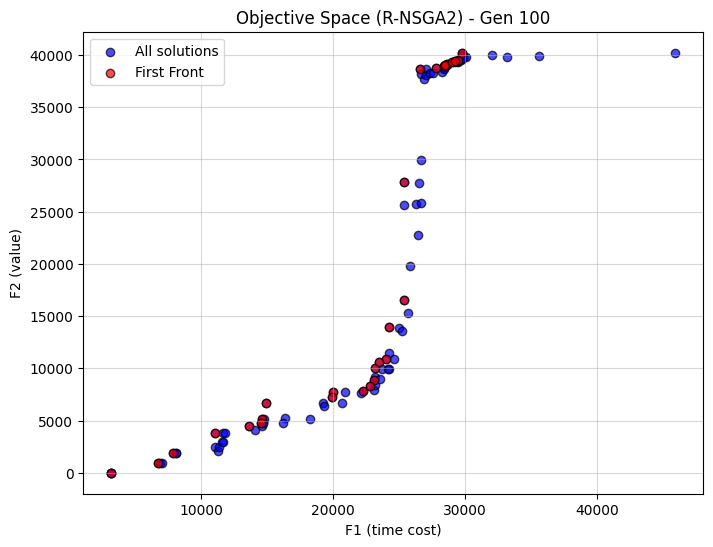

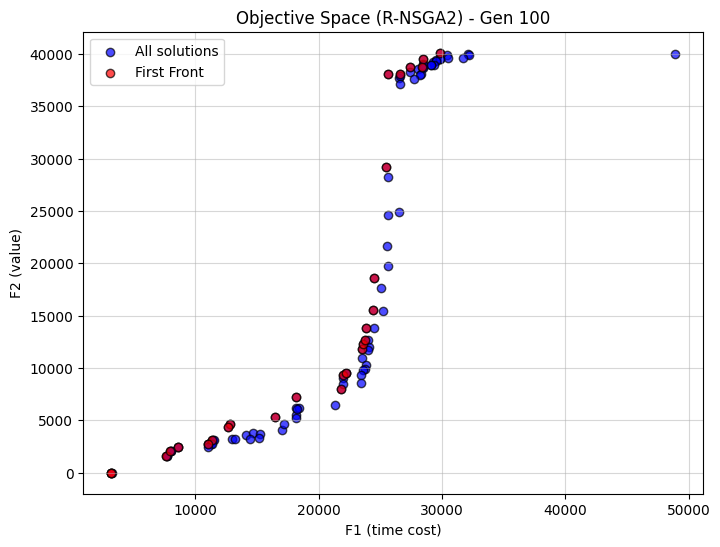

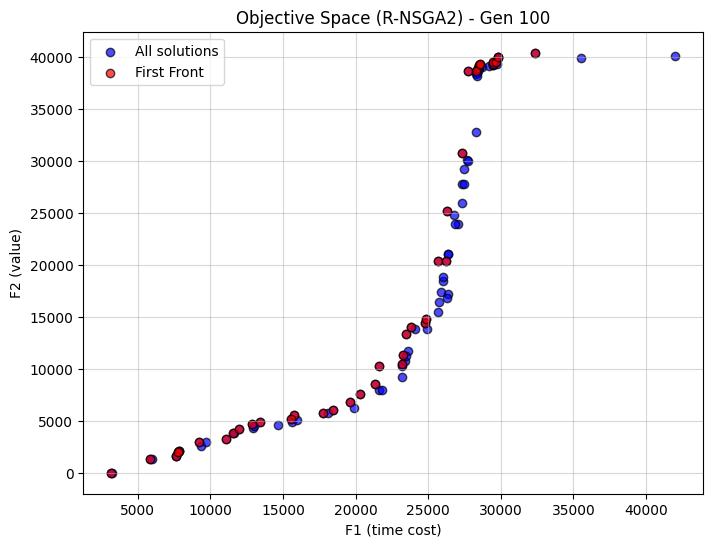

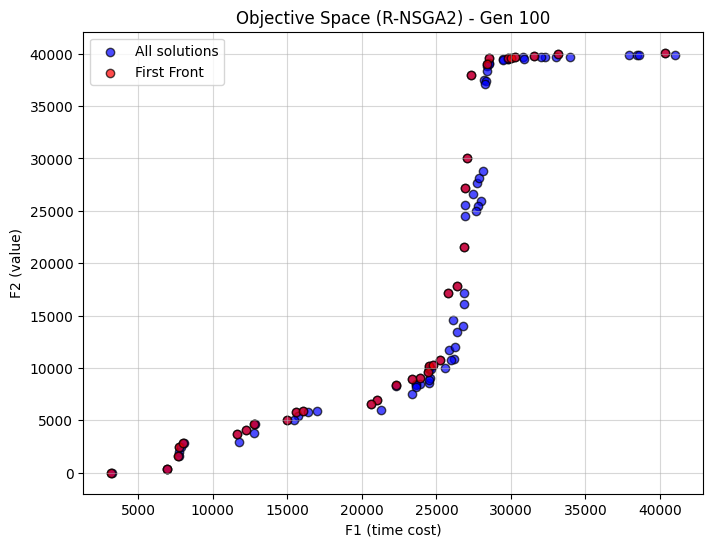

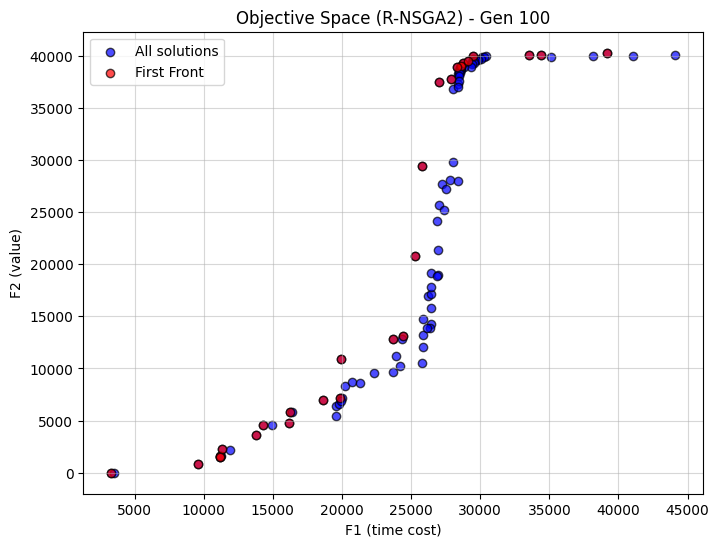

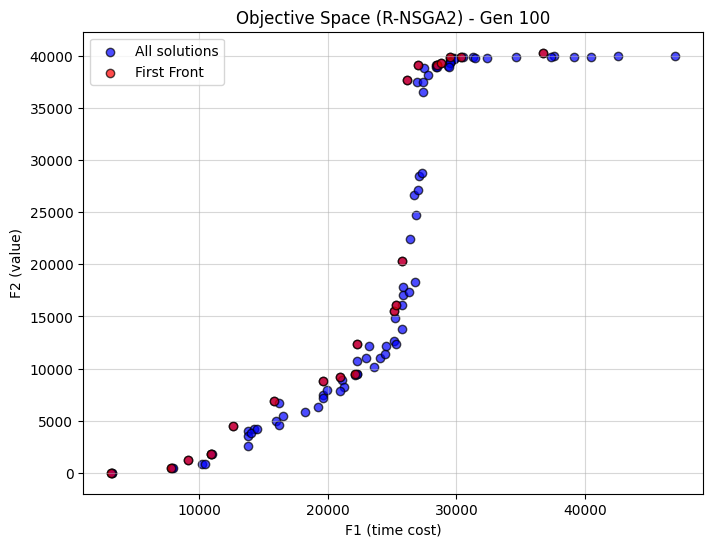

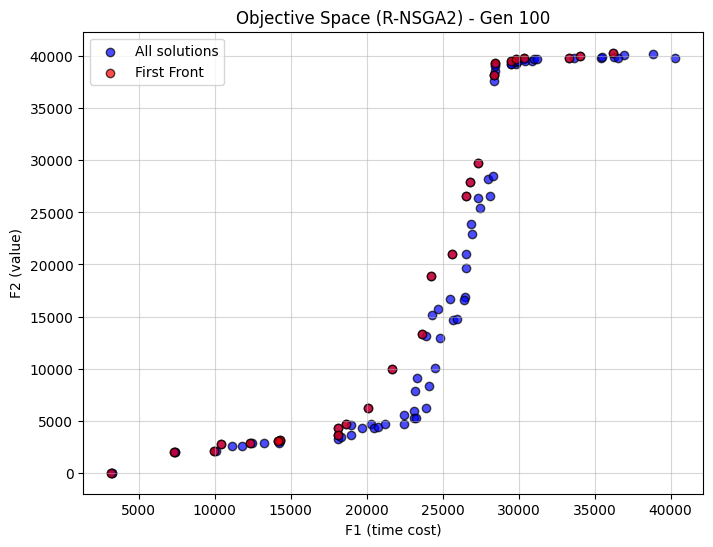

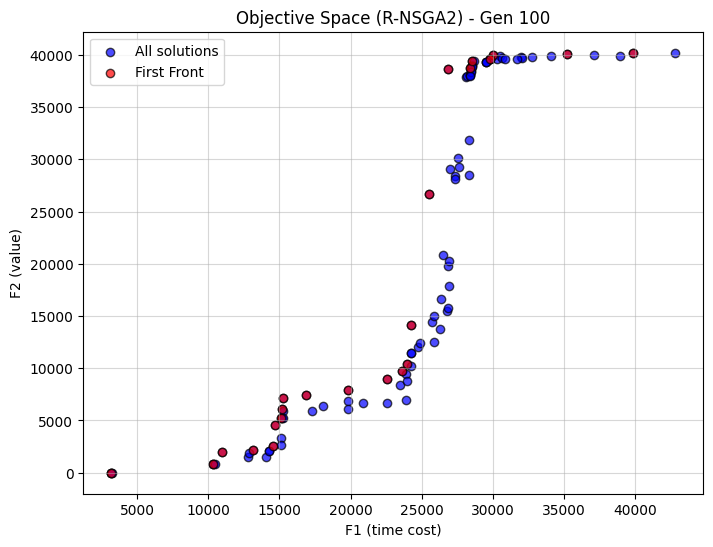

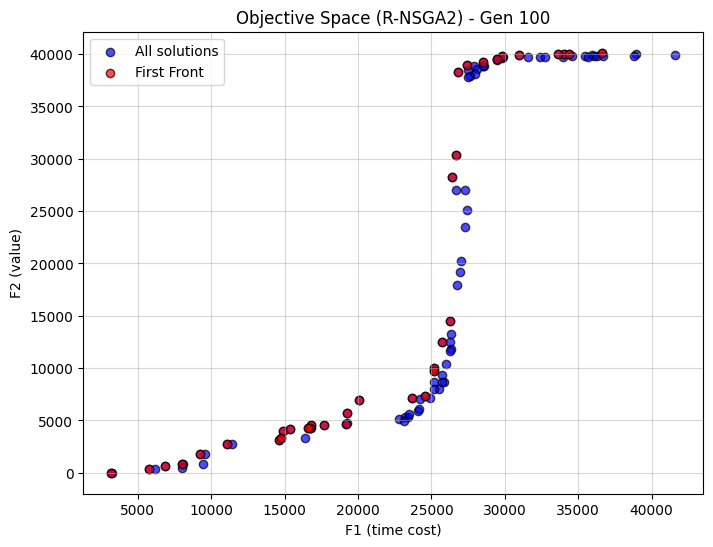

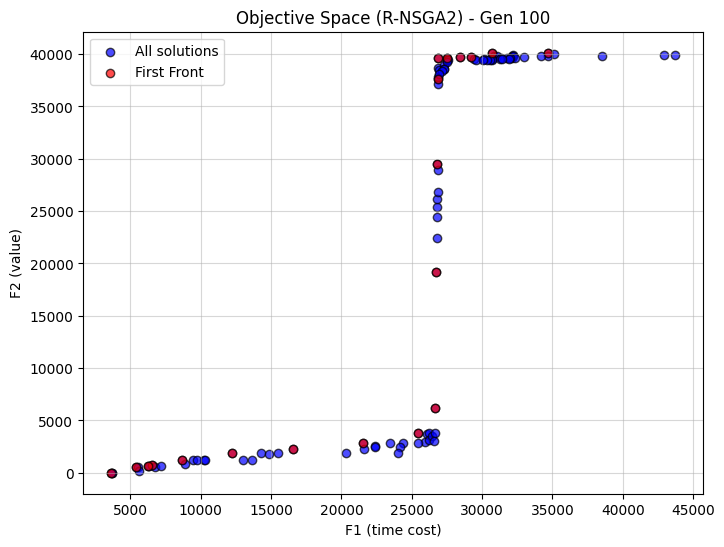

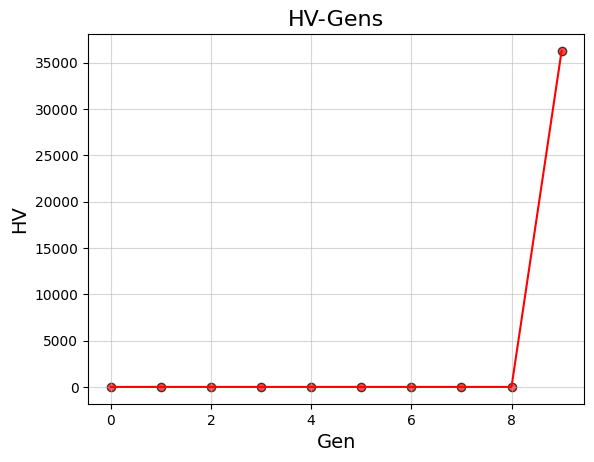

In [ ]:
from pymoo.indicators.hv import Hypervolume
import numpy as np
import random
import matplotlib.pyplot as plt
# opt
C = 1
file_name = 'a280-n279.txt'
# file_name = 'fnl4461-n4460.txt'
pop_size = 100
n_gens = 100
random_seed = 114514
reference_points = read_rp('HPI_a280-n279.f')
hv_point = np.array([5444.0, -0.0])  # Nadir Point
hv = Hypervolume(ref_point=hv_point)
HV = []
res_3 = []


distance_matrix, items, cities_count, items_count = read_ttp_data(file_name)
capacity = np.sum(items[:, 2]) * (C/11)

initial_path, initial_selections = generate_initial_solutions(pop_size, cities_count, items_count, items, C, distance_matrix, random_seed)


plt.figure(figsize=(8, 6))
for i in range(10):
  res_pop = R_NSGA2(
      pop_size = pop_size,
      n_gens = n_gens,
      reference_points = reference_points,
      cities_count = cities_count,
      items_count = items_count,
      items = items,
      C = C,
      distance_matrix = distance_matrix,
      path = initial_path,
      selections = initial_selections,
      random_seed = random_seed,
      cross_rate = 0.8,
      mut_rate = 0.3)
  HV.append(hv.do(res_pop[2]))
  res_3.append(res_pop)
  random_seed += 1


plt.scatter(range(len(HV)), HV, c='r', edgecolors='k', alpha=0.7, label = 'HV')
plt.plot(HV, c='r')

plt.title("HV-Gens", fontsize=16)
plt.xlabel("Gen", fontsize=14)
plt.ylabel("HV", fontsize=14)
plt.grid(alpha=0.5)
plt.show()

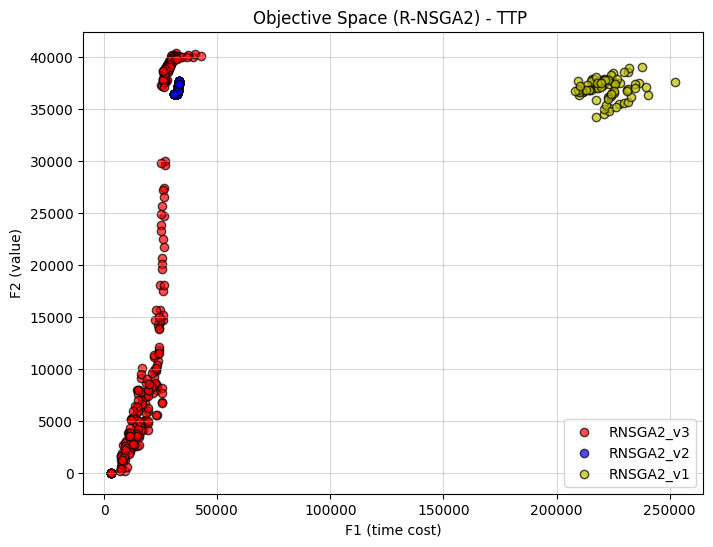

In [ ]:
total_result1 = res[0][2]
total_result2 = res_2[0][2]
total_result3 = res_3[0][2]
for i in range(1, 10):
    total_result3 = np.vstack((total_result3, res_3[i][2]))
    total_result2 = np.vstack((total_result2, res_2[i][2]))
    total_result1 = np.vstack((total_result1, res[i][2]))

# Convert to numpy arrays for slicing, if necessary
import numpy as np
total_result3 = np.array(total_result3)
total_result2 = np.array(total_result2)
total_result1 = np.array(total_result1)

# Adjust slicing depending on your data structure
plt.figure(figsize=(8, 6))
plt.scatter(total_result3[:, 0], -total_result3[:, 1], c='red', edgecolors='k', alpha=0.7, label='RNSGA2_v3')
plt.scatter(total_result2[:, 0], -total_result2[:, 1], c='b', edgecolors='k', alpha=0.7, label='RNSGA2_v2')
plt.scatter(total_result1[:, 0], -total_result1[:, 1], c='y', edgecolors='k', alpha=0.7, label='RNSGA2_v1')
plt.title("Objective Space (R-NSGA2) - TTP ")
plt.xlabel("F1 (time cost)")
plt.ylabel("F2 (value)")
plt.grid(alpha=0.5)
plt.legend()
plt.show()

# plt.figure(figsize=(8, 6))
# plt.scatter(total_result3[:, 0], -total_result3[:, 1], c='red', edgecolors='k', alpha=0.7, label='RNSGA2_v3')
# plt.scatter(total_result2[:, 0], -total_result2[:, 1], c='b', edgecolors='k', alpha=0.7, label='RNSGA2_v2')
# # plt.scatter(total_result1[:, 0], -total_result1[:, 1], c='y', edgecolors='k', alpha=0.7, label='RNSGA2_v1')
# plt.title("Objective Space (R-NSGA2) - TTP ")
# plt.xlabel("F1 (time cost)")
# plt.ylabel("F2 (value)")
# plt.grid(alpha=0.5)
# plt.legend()
# plt.show()

# plt.figure(figsize=(8, 6))
# # plt.scatter(total_result3[:, 0], -total_result3[:, 1], c='red', edgecolors='k', alpha=0.7, label='RNSGA2_v3')
# plt.scatter(total_result2[:, 0], -total_result2[:, 1], c='b', edgecolors='k', alpha=0.7, label='RNSGA2_v2')
# plt.scatter(total_result1[:, 0], -total_result1[:, 1], c='y', edgecolors='k', alpha=0.7, label='RNSGA2_v1')
# plt.title("Objective Space (R-NSGA2) - TTP ")
# plt.xlabel("F1 (time cost)")
# plt.ylabel("F2 (value)")
# plt.grid(alpha=0.5)
# plt.legend()
# plt.show()


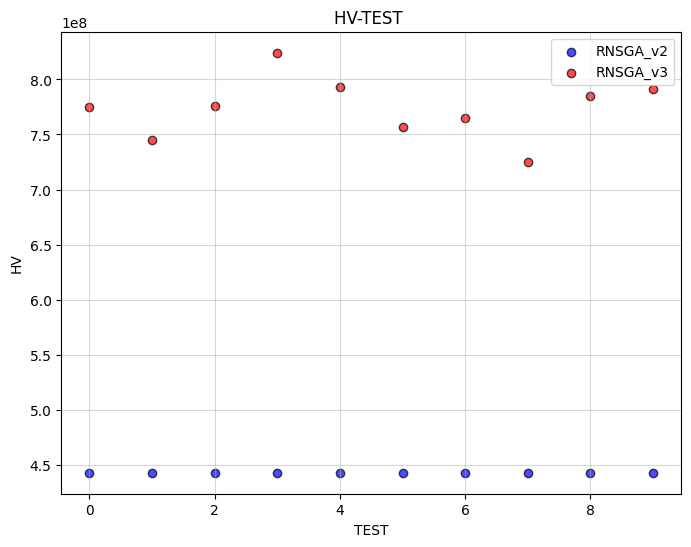

RNSGA2_v2 mean HV:442891951.9257118
RNSGA2_v3 mean HV:773535996.0894699
提升幅度为1.7465569033849107


In [ ]:
from pymoo.indicators.hv import Hypervolume
# rp = [10000, 0]
rp = [max(total_result3[:, 0]), 0]
hv = Hypervolume(rp)
HV2 = []
HV3 = []
for i in range(10):
      HV2.append(hv.do(res_2[i][2]))
      HV3.append(hv.do(res_3[i][2]))

plt.figure(figsize=(8, 6))
plt.scatter(range(len(HV2)), HV2, c='b', edgecolors='k', alpha=0.7, label='RNSGA_v2')
plt.scatter(range(len(HV3)), HV3, c='r', edgecolors='k', alpha=0.7, label='RNSGA_v3')
plt.title("HV-TEST ")
plt.xlabel("TEST")
plt.ylabel("HV")
plt.grid(alpha=0.5)
plt.legend()
plt.show()
print(f'RNSGA2_v2 mean HV:{np.mean(HV2)}')
print(f'RNSGA2_v3 mean HV:{np.mean(HV3)}')
print(f'提升幅度为{np.mean(HV3)/np.mean(HV2)}')


In [ ]:
print(f'RNSGA2_v1 mean F(time cost, profit) :{(np.mean(total_result1[:,0]), -np.mean(total_result1[:,1]))}')
print(f'RNSGA2_v2 mean F(time cost, profit) :{(np.mean(total_result2[:,0]), -np.mean(total_result2[:,1]))}')
print(f'RNSGA2_v3 mean F(time cost, profit) :{(np.mean(total_result3[:,0]), -np.mean(total_result3[:,1]))}')


RNSGA2_v1 mean F(time cost, profit) :(222745.37033894504, 36966.28767123288)
RNSGA2_v2 mean F(time cost, profit) :(32400.880298493837, 36998.857142857145)
RNSGA2_v3 mean F(time cost, profit) :(20998.074069770497, 18819.275862068964)
